## SetUP

In [1]:
# !pip install kneed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from glob import glob

from sklearn import metrics
from sklearn.cluster import KMeans

# !pip install kneed
from kneed import KneeLocator
from scipy.stats import pearsonr
from  scipy.spatial.distance import pdist, squareform
import multiprocessing as mp
import networkx as nx

import pickle

In [2]:
!pwd
import os
os.chdir('./fixMT/notebook/')
!pwd

/pod/2/activities/jaxcc/CATch-project/analysis/tkhan
/pod/2/activities/jaxcc/CATch-project/analysis/tkhan/fixMT/notebook


## process sample metadata

In [3]:
mdata = pd.read_csv("../data/GSE100150_samples.csv", index_col=0)

mdata['sample_ID'] = [i.split(":")[0] for i in mdata.Title]
mdata['sample_group'] = [i.split("-")[-1] for i in mdata.Title]
mdata['study_group'] = ["_".join(i.split(":")[1].split("-")[:-1]) for i in mdata.Title]

In [4]:
mdata.groupby(['study_group','sample_group']).size()

study_group                           sample_group   
whole blood_B_cell deficiency         Bcell              20
                                      Control            13
whole blood_COPD                      COPD               19
                                      Control            24
whole blood_Flu                       Control            14
                                      FLU                25
whole blood_HIV                       Control            35
                                      HIV                28
whole blood_Juvenile Dermatomyositis  Control             9
                                      JDM                40
whole blood_Kawasaki                  Control            23
                                      Kawasaki           21
whole blood_Liver Transplant          Control            30
                                      Transplant         94
whole blood_MS                        Control            22
                                      MS Patie

In [5]:
mdata_tmp = mdata[['sample_ID','sample_group','study_group']]
mdata_tmp['sample_type'] = [i.split("_")[0] for i in mdata_tmp.study_group]
mdata_tmp['study_name'] = ["_".join(i.split("_")[1:]) for i in mdata_tmp.study_group]
mdata_tmp

/tmp/ipykernel_2951458/3003316267.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdata_tmp['sample_type'] = [i.split("_")[0] for i in mdata_tmp.study_group]
/tmp/ipykernel_2951458/3003316267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdata_tmp['study_name'] = ["_".join(i.split("_")[1:]) for i in mdata_tmp.study_group]


,sample_ID,sample_group,study_group,sample_type,study_name
Accession,,,,,
GSM2672129,4433719001_L,Control,whole blood_HIV,whole blood,HIV
GSM2672130,4433719006_J,Control,whole blood_HIV,whole blood,HIV
GSM2672131,4433719006_L,Control,whole blood_HIV,whole blood,HIV
GSM2672132,4433719007_J,Control,whole blood_HIV,whole blood,HIV
GSM2672133,4433719007_L,Control,whole blood_HIV,whole blood,HIV
...,...,...,...,...,...
GSM2673109,4487653398_C,PTB,whole blood_TB,whole blood,TB
GSM2673110,4487653398_D,PTB,whole blood_TB,whole blood,TB
GSM2673111,4487653399_D,PTB,whole blood_TB,whole blood,TB


In [6]:
mdata_tmp.sample_ID.nunique()

949

In [7]:
mdata_tmp.groupby('study_name').size()

study_name
B_cell deficiency            33
COPD                         43
Flu                          39
HIV                          63
Juvenile Dermatomyositis     49
Kawasaki                     44
Liver Transplant            124
MS                           56
Melanoma                     27
Pregnancy                    45
RSV                          84
SLE                          69
Sepsis                       47
SoJIA                        85
Staph                       143
TB                           34
dtype: int64

## Process intensity data

### data filtering 

* from : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8289976/

Gene expression profiles from whole blood samples generated using Illumina HumanHT-12 v3.0 expression BeadChips were obtained from 16 groups of patients and controls selected as above. Thus, 16 datasets were used as the input data (Table 1). The expression data for each dataset were preprocessed and independently clustered. 
1. First, the probes were discarded if they were not detected (detection P < 0.01) in at least 10 samples or in at least 10% of the samples, whichever was greater. 
2. Then, the sample data for each dataset were normalized using the BeadStudio average normalization algorithm. 
3. Once normalized, the signal was transformed such that all signals <10 were set to 10. 
4. Then, the fold change was calculated relative to the median signal for that probe across all samples. If the difference between a signal and the probe’s median signal was <30, or the calculated absolute magnitude of the fold change was <1.2, the fold change was set to 1 to reduce the noise from low-level responses. 
5. At this stage, the probes were filtered again. Probes were only retained if they had a calculated absolute fold change >1 in at least 10 samples or in at least 10% of the samples, whichever was greater. 
6. Finally, the data were transformed to the log2 of the calculated fold changes.

In [8]:
# glob("../data/geoData/*.gz")
glob("../data/geoData_nonNormalized/*.gz")

['../data/geoData_nonNormalized/GSE100154_Kawasaki_non-normalized.txt.gz',
 '../data/geoData_nonNormalized/GSE100166_TB_non-normalized.txt.gz',
 '../data/geoData_nonNormalized/GSE100161_RSV_non-normalized.txt.gz',
 '../data/geoData_nonNormalized/GSE100163_SLE_non-normalized.txt.gz',
 '../data/geoData_nonNormalized/GSE100156_B_Cell_Deficiency_non-normalized.txt.gz',
 '../data/geoData_nonNormalized/GSE100160_Flu_non-normalized.txt.gz',
 '../data/geoData_nonNormalized/GSE100155_Liver_Transplant_non-normalized.txt.gz',
 '../data/geoData_nonNormalized/GSE100152_Juvenile_Dermatomyositis_non-normalized.txt.gz',
 '../data/geoData_nonNormalized/GSE100159_Sepsis_non-normalized.txt.gz',
 '../data/geoData_nonNormalized/GSE100158_Melanoma_non-normalized.txt.gz',
 '../data/geoData_nonNormalized/GSE100151_HIV_non-normalized.txt.gz',
 '../data/geoData_nonNormalized/GSE100157_Pregnancy_non-normalized.txt.gz',
 '../data/geoData_nonNormalized/GSE100162_MS_non-normalized.txt.gz',
 '../data/geoData_nonNorm

In [54]:
def filter1_pvaluebased(flpval,detection_cutoff = 0.01, sample_threshold = 10, sample_pct = 0.1):
    """
    Function to filter probes based on p-value detection threshold
    flpval: pvalue data frame
    detecttion_cutoff: detection cutoff value
    sample_theshold : minimum number of samples for detection (10)
    sample_pct : percentage of samples for detection (10%)

    return: filtered pvalue index names
    """
    # get threshold for sample detection : 10% of samples or 10 samples whichever is greater
    sample_threshold = max(sample_threshold, sample_pct * flpval.shape[1])
    probes_detected = flpval[flpval<detection_cutoff].fillna(0).astype(bool).sum(axis=1).sort_values(ascending=False)
    probes_detected = probes_detected[probes_detected>sample_threshold]
    return probes_detected.index


def beadstudio_average_normalization(df):
    """
    Apply BeadStudio average normalization to each array (column) in the DataFrame.
    
    Parameters:
    - df: A pandas DataFrame where rows are genes/probes and columns are samples/arrays.
    
    Returns:
    - normalized_df: A DataFrame with average-normalized expression values.
    """
    # Calculate the mean intensity for each array
    array_means = df.mean(axis=0)
    global_mean = array_means.mean()  # Global mean intensity across all arrays
    
    # Calculate normalization factor for each array
    normalization_factors = global_mean / array_means
    
    # Apply normalization factors to each column
    normalized_df = df.multiply(normalization_factors, axis=1)
    
    return normalized_df


def process_countfile(flname,detection_cutoff = 0.01):
    try:
        # df=pd.read_csv(flname,compression='gzip',sep='\t',index_col=0)
        df = pd.read_csv(flname, sep="\t", compression='gzip', index_col=0, on_bad_lines='skip')
    except:
        df=pd.read_csv(flname,sep='\t',index_col=0)
    # get coulms with pvalues for filtering
    fpval = df[df.columns[df.columns.str.contains("Pval")]]
    print ("Initial: ", flname,fpval.shape)
    # 1.[Filter] Filter probes based on p-value detection threshold
    probes_detected = filter1_pvaluebased(fpval,detection_cutoff)
    # pvalue filter data
    df2 = df.loc[probes_detected]
    print ("After pvalue filtering: ", df2.shape)
    # filter data and take only detection values
    ffilter = df2.drop(fpval.columns,axis=1).astype(float)
    print ("intensities after pvalue filtering: ", ffilter.shape)
    # assertion : make sure sample_ID are in sample_tmp daataframe
    ffilter1 = ffilter.loc[:,ffilter.columns.isin(mdata_tmp.sample_ID)]
    print ("Filtered step 1: ", ffilter1.shape)
    # 2. [transform] apply beadstudio normalization
    ffilter2 = beadstudio_average_normalization(ffilter1)
    print ("BeadStudio normalization: ", ffilter2.shape)

    # 3. [transformed] the signal was transformed such that all signals <10 were set to 10.
    ffilter3 = ffilter2.clip(10)
    print ("clipping intensities: ", ffilter3.shape)
    # 4. [transformed] the fold change was calculated relative to the median signal for that probe across all samples
    # If the difference between a signal and the probe’s median signal was <30, 
    # or the calculated absolute magnitude of the fold change was <1.2, the fold change was set to 1 to reduce the noise from low-level responses. 
    ffilter4 = np.log(ffilter3.div(ffilter3.median(axis=1),axis=0))
    print ("Fold change relative to median: ", ffilter4.shape)
    return ffilter4
    # 5. [transformed] the calculated absolute magnitude of the fold change was <1.2, the fold change was set to 1 
    # to reduce the noise from low-level responses
    # ffilter5 = ffilter4.where(ffilter4.abs()<1.2,1)
    # print ("Filtered fold change: ", ffilter5.shape)
    # # 6. [Filter] robes were only retained if they had a calculated absolute fold change >1 in at least 10 samples or in at least 10% of the samples, whichever was greater
    # sample_threshold = max(10,0.1 * ffilter5.shape[1])
    # print ("[sample filter threshold: ", sample_threshold)
    # probes_filtered = ffilter5[ffilter5.abs()>=1].count(axis=1) # chnage from >1 to >=1
    # probes_filtered = probes_filtered[probes_filtered>=sample_threshold].index
    # ffilter6 = ffilter5.loc[probes_filtered]
    # # 7. [transformed] the data were transformed to the log2 of the calculated fold changes.
    # print ("Filtered data: " ,ffilter6.shape)
    # return ffilter6


### Test

In [17]:
flname = "../data/geoData_nonNormalized/GSE100151_HIV_non-normalized.txt.gz"

try:
    # df=pd.read_csv(flname,compression='gzip',sep='\t',index_col=0)
    df = pd.read_csv(flname, sep="\t", compression='gzip', index_col=0, on_bad_lines='skip')
except:
    df=pd.read_csv(flname,sep='\t',index_col=0)
# get coulms with pvalues for filtering
fpval = df[df.columns[df.columns.str.contains("Pval")]]
print ("Initial: ", flname,fpval.shape)

Initial:  ../data/geoData_nonNormalized/GSE100151_HIV_non-normalized.txt.gz (48803, 63)


/tmp/ipykernel_2951458/618830.py:5: DtypeWarning: Columns (127,128,129,130,131,132,133) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(flname, sep="\t", compression='gzip', index_col=0, on_bad_lines='skip')


In [20]:
# 1.[Filter] Filter probes based on p-value detection threshold
probes_detected = filter1_pvaluebased(fpval,detection_cutoff=0.01)
# pvalue filter data
df2 = df.loc[probes_detected]
print ("After pvalue filtering: ", df2.shape)
# filter data and take only detection values
ffilter = df2.drop(fpval.columns,axis=1).astype(float)
print ("intensities after pvalue filtering: ", ffilter.shape)
# assertion : make sure sample_ID are in sample_tmp daataframe
ffilter1 = ffilter.loc[:,ffilter.columns.isin(mdata_tmp.sample_ID)]
print ("Filtered step 1: ", ffilter1.shape)

After pvalue filtering:  (8131, 139)
intensities after pvalue filtering:  (8131, 76)
Filtered step 1:  (8131, 63)


In [21]:
# 2. [transform] apply beadstudio normalization
ffilter2 = beadstudio_average_normalization(ffilter1)
print ("BeadStudio normalization: ", ffilter2.shape)

# 3. [transformed] the signal was transformed such that all signals <10 were set to 10.
ffilter3 = ffilter2.clip(10)
print ("clipping intensities: ", ffilter3.shape)
# 4. [transformed] the fold change was calculated relative to the median signal for that probe across all samples
# If the difference between a signal and the probe’s median signal was <30, 
# or the calculated absolute magnitude of the fold change was <1.2, the fold change was set to 1 to reduce the noise from low-level responses. 
ffilter4 = np.log(ffilter3.div(ffilter3.median(axis=1),axis=0))
print ("Fold change relative to median: ", ffilter4.shape)

BeadStudio normalization:  (8131, 63)
clipping intensities:  (8131, 63)
Fold change relative to median:  (8131, 63)


In [47]:
# 5. [transformed] the calculated absolute magnitude of the fold change was <1.2, the fold change was set to 1 
# to reduce the noise from low-level responses
ffilter5 = ffilter4.where(ffilter4.abs()<1.2,1)
print ("Filtered fold change: ", ffilter5.shape)

Filtered fold change:  (8131, 63)


<Axes: ylabel='Frequency'>

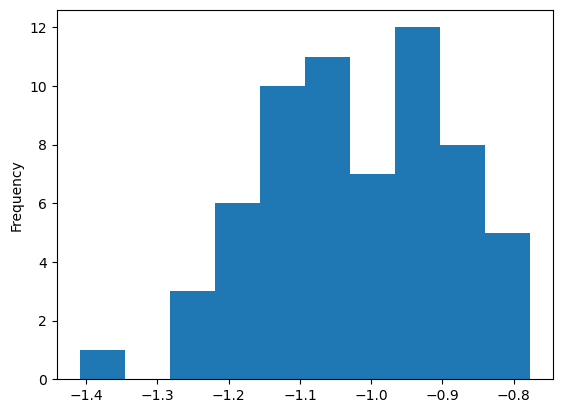

In [35]:
np.log10(ffilter3.div(ffilter3.median(axis=1),axis=0)).min().plot.hist()

In [53]:
ffilter5

,4433719009_D,4424548056_A,4433719009_G,4433719009_I,4424548056_G,4433719009_K,4433719010_A,4433719010_C,4433719010_G,4424548057_D,...,4424548053_G,4433719006_L,4433719007_A,4424548055_A,4433719007_F,4433719007_J,4424548055_G,4433719007_L,4433719009_A,4433719009_B
ID_REF,,,,,,,,,,,,,,,,,,,,,
ILMN_1786275,-0.096010,-0.209230,0.052339,0.017532,-0.232650,-0.036077,0.037038,-0.100210,0.306008,0.221175,...,0.079892,-0.082331,-0.167437,0.056905,0.076752,0.085948,-0.052234,0.216394,0.002335,-0.109553
ILMN_1786684,0.225841,-0.083943,-0.013388,0.090754,-0.089885,0.361492,0.160702,-0.181412,0.195281,0.464937,...,0.291641,-0.587344,0.236250,0.101370,0.386042,0.194161,0.500151,0.215819,0.023019,-0.326956
ILMN_1655663,-0.179779,0.351644,0.135385,0.000000,0.130257,-0.207591,-0.012633,0.214088,0.356414,0.139406,...,0.441708,-0.259500,-0.267829,-0.044371,-0.173226,0.270578,0.344783,0.136929,0.184680,0.005875
ILMN_2402079,-0.026832,-0.107228,-0.347263,0.302830,-0.101256,-0.087603,0.203497,-0.024231,0.093239,0.103498,...,-0.235800,0.069887,0.148306,0.121908,0.071671,-0.034741,-0.093018,-0.085350,-0.019005,0.246415
ILMN_1748970,-0.646502,0.388636,0.022963,-0.012735,-0.271504,-0.240774,-0.049119,0.152327,0.000000,0.214219,...,0.005699,0.039699,0.402743,0.155985,-0.035568,0.057034,0.022455,0.020530,-0.009662,-0.128062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ILMN_1675844,0.002597,-0.278212,0.135814,-0.329147,-0.064811,0.195277,-0.756475,-0.699819,0.047894,0.013143,...,-0.002319,-0.548530,-0.057831,0.361664,-0.317942,-0.479426,-0.132600,0.169200,-0.283107,-1.056436
ILMN_1748352,-0.519858,-0.489011,-0.085311,-0.519858,0.315372,-0.516132,-0.055448,0.602623,0.259922,0.098591,...,0.198076,0.159918,0.016197,0.026574,-0.173365,0.014713,-0.281890,-0.332216,-0.519858,-0.014234
ILMN_1708482,-0.016605,-0.092942,0.091916,-0.177358,-0.558611,0.274048,0.441364,0.341893,0.508791,0.146443,...,-0.209137,-0.006499,0.259422,-0.219878,0.069047,0.605470,0.142184,0.474090,0.000000,0.501962


In [51]:
ffilter5.index[ffilter5[ffilter5.abs()>=1].count(axis=1)>=10]

Index(['ILMN_1823809', 'ILMN_1744949', 'ILMN_1743241', 'ILMN_1719867',
       'ILMN_1693207', 'ILMN_1814200', 'ILMN_1735179', 'ILMN_2270100',
       'ILMN_1779071', 'ILMN_1706483',
       ...
       'ILMN_2362545', 'ILMN_1751776', 'ILMN_1663447', 'ILMN_1740291',
       'ILMN_1746788', 'ILMN_1804618', 'ILMN_1779852', 'ILMN_1664516',
       'ILMN_1693262', 'ILMN_1710303'],
      dtype='object', name='ID_REF', length=619)

In [55]:

f = process_countfile(flname)

Initial:  ../data/geoData_nonNormalized/GSE100151_HIV_non-normalized.txt.gz (48803, 63)
After pvalue filtering:  (8131, 139)
intensities after pvalue filtering:  (8131, 76)
Filtered step 1:  (8131, 63)
BeadStudio normalization:  (8131, 63)
clipping intensities:  (8131, 63)
Fold change relative to median:  (8131, 63)


/tmp/ipykernel_2951458/320686563.py:44: DtypeWarning: Columns (127,128,129,130,131,132,133) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(flname, sep="\t", compression='gzip', index_col=0, on_bad_lines='skip')


<Axes: >

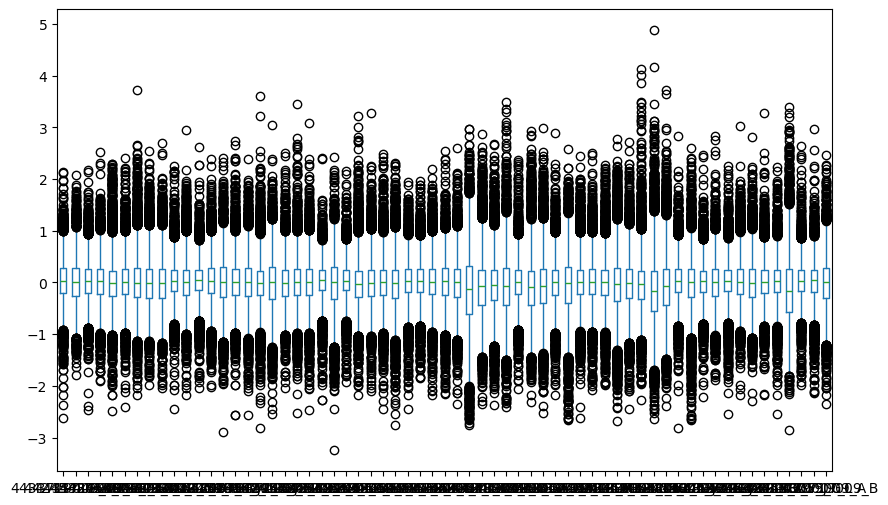

In [56]:
f.plot(kind='box', figsize=(10, 6))

### work with normalized data

In [10]:
processed_files = {}
for k in glob("../data/geoData/*.gz"):
    disease_type = "_".join(k.split("/")[-1].split("_")[1:-1])
    print (k,disease_type)
    processed_files[disease_type] = process_countfile(k)
    print ("*"*20,"End","*"*30)


../data/geoData/GSE100152_Juvenile_Dermatomyositis_normalized.txt.gz Juvenile_Dermatomyositis
Initial:  ../data/geoData/GSE100152_Juvenile_Dermatomyositis_normalized.txt.gz (48803, 49)
After pvalue filtering:  (5634, 98)
intensities after pvalue filtering:  (5634, 49)
Filtered step 1:  (5634, 49)
BeadStudio normalization:  (5634, 49)
clipping intensities:  (5634, 49)
Fold change relative to median:  (5634, 49)
Filtered fold change:  (5634, 49)
Filtered data:  (18, 49)
******************** End ******************************
../data/geoData/GSE100158_Melanoma_normalized.txt.gz Melanoma
Initial:  ../data/geoData/GSE100158_Melanoma_normalized.txt.gz (48803, 27)
After pvalue filtering:  (6333, 54)
intensities after pvalue filtering:  (6333, 27)
Filtered step 1:  (6333, 27)
BeadStudio normalization:  (6333, 27)
clipping intensities:  (6333, 27)
Fold change relative to median:  (6333, 27)
Filtered fold change:  (6333, 27)
Filtered data:  (7, 27)
******************** End **********************

In [41]:
flname = "../data/geoData_nonNormalized/GSE100158_Melanoma_non-normalized.txt.gz"
df = pd.read_csv(flname, sep="\t", compression='gzip', index_col=0, on_bad_lines='skip')

# get coulms with pvalues for filtering
fpval = df[df.columns[df.columns.str.contains("Pval")]]
print ("Initial: ", flname,fpval.shape)
# 1.[Filter] Filter probes based on p-value detection threshold
detection_cutoff = 0.01
probes_detected = filter1_pvaluebased(fpval,detection_cutoff)
# pvalue filter data
df = df.loc[probes_detected]
# filter data and take only detection values
ffilter = df.drop(fpval.columns,axis=1).astype(float)
# assertion : make sure sample_ID are in sample_tmp daataframe
ffilter = ffilter.loc[:,ffilter.columns.isin(mdata_tmp.sample_ID)]
print ("Filtered step 1: ", ffilter.shape)

# 2. [transform] apply beadstudio normalization
ffilter_1 = beadstudio_average_normalization(ffilter)
# 3. [transformed] the signal was transformed such that all signals <10 were set to 10.
ffilter_1 = ffilter_1.clip(10)
print ("clipping intensities: ", ffilter_1.shape)
# 4. [transformed] the fold change was calculated relative to the median signal for that probe across all samples
ffilter_2 = np.log2(ffilter_1.div(ffilter_1.median(axis=1),axis=0))
print ("Fold change relative to median: ", ffilter_2.shape)
# 5. [transformed] the calculated absolute magnitude of the fold change was <1.2, the fold change was set to 1 
# to reduce the noise from low-level responses
# If the difference between a signal and the probe’s median signal was <30, or the calculated absolute magnitude of 
# the fold change was <1.2, the fold change was set to 1 to reduce the noise from low-level responses. 
ffilter_3 = ffilter_2.where(ffilter_2.abs()>1.2,1)
print ("filtered fold change: ", ffilter_3.shape)
# 6. [Filter] robes were only retained if they had a calculated absolute fold change >1 in at least 10 samples or in at least 10% of the samples, whichever was greater
sample_threshold = max(10,0.1 * ffilter_3.shape[1])
probes_filtered = ffilter_3[ffilter_3.abs()>=1].count(axis=1)
probes_filtered = probes_filtered[probes_filtered>sample_threshold].index
# filter
ffilter_4 = ffilter_3.loc[probes_filtered]
print (ffilter_4.shape)
# # 7. [transformed] the data were transformed to the log2 of the calculated fold changes.
# ffilter_4 = np.log2(ffilter_3)
print ("Filtered data: " ,ffilter_4.shape)

Initial:  ../data/geoData_nonNormalized/GSE100158_Melanoma_non-normalized.txt.gz (48803, 27)
Filtered step 1:  (6333, 27)
clipping intensities:  (6333, 27)
Fold change relative to median:  (6333, 27)
filtered fold change:  (6333, 27)
(6333, 27)
Filtered data:  (6333, 27)


<Axes: ylabel='Frequency'>

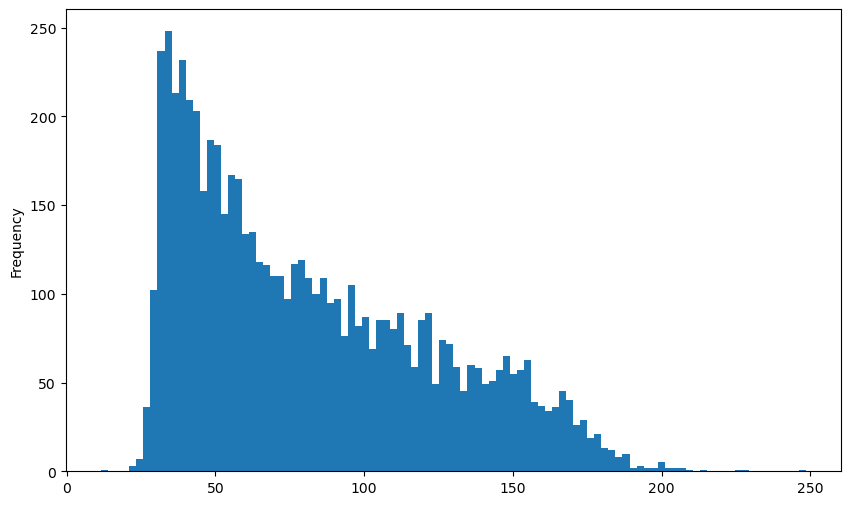

In [34]:
ffilter_1.median(axis=1).plot(kind='hist', bins=100, figsize=(10, 6))

In [40]:
# substract each value from the median
np.log(ffilter_1.div(ffilter_1.median(axis=1),axis=0))

,4710384024_L,4710384046_D,4710384046_F,4710384028_F,4710384028_G,4710384046_L,4710384028_L,4710384029_E,4710384030_I,4710384034_G,...,4710384041_H,4710384022_H,4710384022_I,4710384022_K,4710384042_C,4710384022_L,4710384036_H,4710384024_A,4710384024_B,4710384042_L
ID_REF,,,,,,,,,,,,,,,,,,,,,
ILMN_1729115,0.336690,0.124523,-0.174374,0.114124,-0.474916,-0.001180,0.455965,-0.298829,0.326130,0.253483,...,0.047303,0.502062,0.413223,0.188441,-0.226608,-0.085089,-0.374397,-0.536977,-0.262514,-0.528411
ILMN_2349129,0.303175,0.063333,-0.051464,-0.066771,-0.226678,0.301311,-0.263851,-0.236558,-0.146944,0.098786,...,0.405630,-0.173586,0.238220,-0.011415,-0.243622,0.183743,0.067934,0.014388,0.051404,0.000000
ILMN_1750876,0.569065,0.219704,-0.069545,-0.069238,-0.020532,-0.496942,0.119043,0.027982,-0.274012,0.168157,...,-0.483698,-0.650965,0.397086,0.002575,0.062296,-0.082443,-0.186169,-0.093869,0.000000,0.045621
ILMN_1715508,0.606366,0.172406,0.168690,0.557183,-0.117493,0.277954,0.356817,-0.008746,0.428788,-0.287804,...,0.000000,0.111950,-0.163635,-0.211538,-0.133434,-0.115027,-0.192071,-0.321935,-0.085181,0.034207
ILMN_1726698,0.904209,0.086486,0.212831,0.124235,0.045874,0.260398,-0.022092,-0.095559,0.071802,0.000000,...,-0.179502,-0.003228,0.141710,-0.752431,-0.573034,-0.068253,0.241307,-0.232181,0.132096,0.244135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ILMN_2189869,-0.136149,-0.223341,0.000000,-1.021753,0.170645,-0.393994,0.152732,0.172169,-0.397994,0.102298,...,0.273118,0.055348,0.197340,0.784638,0.382721,0.234411,-0.109896,-0.367294,-0.105836,0.126835
ILMN_1811555,0.037933,0.099450,-0.256175,-0.377611,0.000000,-0.198557,-0.468177,-0.261310,-0.536823,-0.275142,...,0.246660,-0.147508,0.059229,0.200401,-0.089224,0.171521,0.044049,0.007069,0.024855,-0.161207
ILMN_1813175,0.418103,-1.106969,-0.906429,0.388782,0.241410,-1.106969,-1.060451,0.373476,1.011420,-0.085091,...,-0.616257,0.473975,-0.029228,0.295851,-0.043895,-0.281193,-0.257180,1.227849,0.125271,0.012611


In [19]:
sample_threshold = max(10, 0.1 * fpval.shape[1])
probes_detected = fpval[fpval<detection_cutoff].fillna(0).astype(bool).sum(axis=1).sort_values(ascending=False)
probes_detected = probes_detected[probes_detected>sample_threshold]
print (probes_detected.shape)

(6333,)


In [22]:
fpval[fpval<detection_cutoff].fillna(0).astype(bool).sum(axis=0).sort_values(ascending=False)

Detection Pval.8     7785
Detection Pval.5     7710
Detection Pval.6     7006
Detection Pval.23    6983
Detection Pval.3     6765
Detection Pval.19    6742
Detection Pval.2     6643
Detection Pval.17    6493
Detection Pval.18    6477
Detection Pval.14    5993
Detection Pval.9     5910
Detection Pval.11    5872
Detection Pval.16    5672
Detection Pval.7     5659
Detection Pval.13    5586
Detection Pval.1     5442
Detection Pval.12    5432
Detection Pval.22    5198
Detection Pval.15    5152
Detection Pval.20    5060
Detection Pval.21    4998
Detection Pval.10    4843
Detection Pval.25    4600
Detection Pval.4     4139
Detection Pval.26    3686
Detection Pval.24    3070
Detection Pval       2854
dtype: int64

In [45]:
for k in processed_files:
    sname = k.replace("_"," ")
    print (k,processed_files[k].shape, mdata_tmp[mdata_tmp.study_name.str.contains(sname)].shape)
    try:
        assert processed_files[k].shape[1] == mdata_tmp[mdata_tmp.study_name.str.contains(sname)].shape[0]
    except:
        print ("** Mismatch in sample size: ", k,processed_files[k].shape[1], mdata_tmp[mdata_tmp.study_name.str.contains(sname)].shape[0])

Juvenile_Dermatomyositis (4128, 49) (49, 5)
Melanoma (552, 27) (27, 5)
Pregnancy (4054, 45) (45, 5)
Staph (9308, 143) (143, 5)
B_Cell_Deficiency (2359, 33) (0, 5)
** Mismatch in sample size:  B_Cell_Deficiency 33 0
SLE (9138, 69) (69, 5)
Liver_Transplant (9581, 124) (124, 5)
SoJIA (8847, 85) (85, 5)
Kawasaki (4949, 44) (44, 5)
COPD (4603, 43) (43, 5)
Sepsis (7098, 47) (47, 5)
MS (6449, 56) (56, 5)
RSV (6035, 84) (84, 5)
TB (2625, 34) (34, 5)
HIV (7809, 63) (63, 5)
Flu (2568, 39) (39, 5)


In [161]:
for k in processed_files:
    sname = k.replace("_"," ")
    print (k,processed_files[k].shape, mdata_tmp[mdata_tmp.study_name.str.contains(sname)].shape)
    try:
        assert processed_files[k].shape[1] == mdata_tmp[mdata_tmp.study_name.str.contains(sname)].shape[0]
    except:
        print ("** Mismatch in sample size: ", k,processed_files[k].shape[1], mdata_tmp[mdata_tmp.study_name.str.contains(sname)].shape[0])


Juvenile_Dermatomyositis (5867, 49) (49, 5)
Melanoma (8455, 27) (27, 5)
Pregnancy (7508, 45) (45, 5)
Staph (7143, 143) (143, 5)
B_Cell_Deficiency (7132, 33) (0, 5)
** Mismatch in sample size:  B_Cell_Deficiency 33 0
SLE (8371, 69) (69, 5)
Liver_Transplant (7577, 124) (124, 5)
SoJIA (7140, 85) (85, 5)
Kawasaki (6596, 44) (44, 5)
COPD (8265, 43) (43, 5)
Sepsis (7805, 47) (47, 5)
MS (7665, 56) (56, 5)
RSV (6035, 84) (84, 5)
TB (8073, 34) (34, 5)
HIV (7552, 63) (63, 5)
Flu (5755, 39) (39, 5)


<Axes: ylabel='Frequency'>

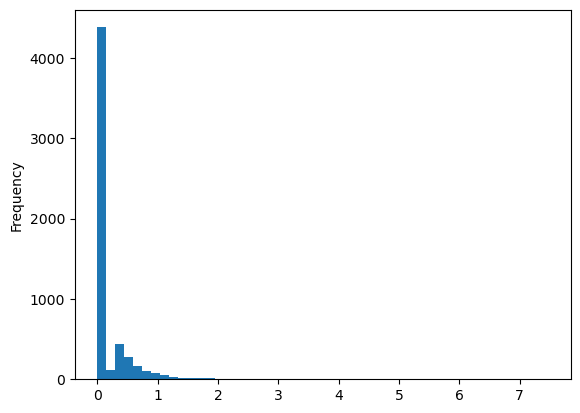

In [177]:
processed_files[k]['4457260030_C'].plot(kind='hist', bins=50)

### Checkpoint for processed data

In [178]:
import pickle

# Save the processed_files dictionary to a pickle file
with open('processed_files.pkl', 'wb') as f:
    pickle.dump(processed_files, f)

### Work with non-normalized data

In [57]:
processed_files = {}

for k in glob("../data/geoData_nonNormalized/*.gz"):
    disease_type = "_".join(k.split("/")[-1].split("_")[1:-1])
    print (k,disease_type)
    processed_files[disease_type] = process_countfile(k)
    print ("*"*20,"End","*"*30)


../data/geoData_nonNormalized/GSE100154_Kawasaki_non-normalized.txt.gz Kawasaki
Initial:  ../data/geoData_nonNormalized/GSE100154_Kawasaki_non-normalized.txt.gz (48803, 44)
After pvalue filtering:  (5853, 88)
intensities after pvalue filtering:  (5853, 44)
Filtered step 1:  (5853, 44)
BeadStudio normalization:  (5853, 44)
clipping intensities:  (5853, 44)
Fold change relative to median:  (5853, 44)
******************** End ******************************
../data/geoData_nonNormalized/GSE100166_TB_non-normalized.txt.gz TB
Initial:  ../data/geoData_nonNormalized/GSE100166_TB_non-normalized.txt.gz (48803, 34)
After pvalue filtering:  (6579, 68)
intensities after pvalue filtering:  (6579, 34)
Filtered step 1:  (6579, 34)
BeadStudio normalization:  (6579, 34)
clipping intensities:  (6579, 34)
Fold change relative to median:  (6579, 34)
******************** End ******************************
../data/geoData_nonNormalized/GSE100161_RSV_non-normalized.txt.gz RSV
Initial:  ../data/geoData_nonNor

/tmp/ipykernel_2951458/320686563.py:44: DtypeWarning: Columns (127,128,129,130,131,132,133) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(flname, sep="\t", compression='gzip', index_col=0, on_bad_lines='skip')


Initial:  ../data/geoData_nonNormalized/GSE100151_HIV_non-normalized.txt.gz (48803, 63)
After pvalue filtering:  (8131, 139)
intensities after pvalue filtering:  (8131, 76)
Filtered step 1:  (8131, 63)
BeadStudio normalization:  (8131, 63)
clipping intensities:  (8131, 63)
Fold change relative to median:  (8131, 63)
******************** End ******************************
../data/geoData_nonNormalized/GSE100157_Pregnancy_non-normalized.txt.gz Pregnancy
Initial:  ../data/geoData_nonNormalized/GSE100157_Pregnancy_non-normalized.txt.gz (48803, 45)
After pvalue filtering:  (7247, 90)
intensities after pvalue filtering:  (7247, 45)
Filtered step 1:  (7247, 45)
BeadStudio normalization:  (7247, 45)
clipping intensities:  (7247, 45)
Fold change relative to median:  (7247, 45)
******************** End ******************************
../data/geoData_nonNormalized/GSE100162_MS_non-normalized.txt.gz MS
Initial:  ../data/geoData_nonNormalized/GSE100162_MS_non-normalized.txt.gz (48803, 56)
After pval

### Chekpoint non normalized data

In [58]:
# Save the processed_files dictionary to a pickle file
with open('../ckpnt/processed_files_nonNormalized.pkl', 'wb') as f:
    pickle.dump(processed_files, f)

## clustering expression profile

each of the preprocessed microarray datasets was clustered in parallel using Euclidean distance and Hartigan’s k-means clustering algorithm. 
1. The ‘ideal’ number of clusters (k) for each dataset was determined within a range of k = 1–100 using the jump statistic. 
2. Taking the 16 sets of clusters as the input data (Table 1), a weighted co-cluster graph was constructed16,18. 
3. To select modules, an iterative algorithm was used to extract the sets of probes that are most frequently clustered together in the same datasets, proceeding from the most stringent requirements to the least, as previously described18.

4.  This iterative process differed from the previous implementation of this algorithm in that the k value was calculated independently for each dataset cluster and the size of the core sub-networks was smaller (10 probes). The algorithm also differed from previous implementations to ensure that the core sub-networks co-clustered in the same datasets. 

5. The resulting 382 module set constitutes the third generation of the modular blood transcriptome repertoire constructed since the development of the first generation published in 2008, and the second generation published in 2013. 

6. Module identifiers (Mxx.xx) were attributed, with the first number indicating the round of selection (the smaller the number the higher the number of datasets in which co-clustering was observed; for M1 it would be 16/16; for M2 it would be 15/16 etc.); the next number represents the order in which it was selected (the smaller the number, the larger the size of the initial seed).

In [59]:
from tqdm import tqdm

def test_clustering(dmatrix, min_size=10, max_size=100):
    vr_crit = []

    for i in tqdm(range(min_size, max_size), desc="Clustering Progress"):
        km = KMeans(n_clusters=i, random_state=1, max_iter=100).fit(dmatrix)
        c_score = metrics.calinski_harabasz_score(dmatrix, km.labels_)  # Variance Ratio Criterion
        sil_score = metrics.silhouette_score(dmatrix, km.labels_, metric='euclidean')
        vr_crit.append([i, km.inertia_, c_score, sil_score])
    
    clusterEnergy = pd.DataFrame(vr_crit, columns=['k', 'inertia', 'calinski_harabasz_score', 'silhouette_score'])
    return clusterEnergy

def parallel_clustering(dmatrix, min_size=25, max_size=100):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.starmap(test_clustering, [(dmatrix, i, max_size) for i in range(min_size, max_size)])
    return pd.concat(results, ignore_index=True)

print (processed_files.keys())

dict_keys(['Kawasaki', 'TB', 'RSV', 'SLE', 'B_Cell_Deficiency', 'Flu', 'Liver_Transplant', 'Juvenile_Dermatomyositis', 'Sepsis', 'Melanoma', 'HIV', 'Pregnancy', 'MS', 'Staph', 'SoJIA', 'COPD'])


In [60]:
clusterEnergy_samples = pd.DataFrame()

for k in processed_files.keys():
    print (k)
    tmp = test_clustering(processed_files[k])
    tmp['disease_type'] = k
    clusterEnergy_samples = pd.concat([clusterEnergy_samples,tmp],axis=0)

Kawasaki


Clustering Progress: 100%|██████████| 90/90 [00:43<00:00,  2.05it/s]


TB


Clustering Progress: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]


RSV


Clustering Progress: 100%|██████████| 90/90 [00:58<00:00,  1.55it/s]


SLE


Clustering Progress: 100%|██████████| 90/90 [01:38<00:00,  1.10s/it]


B_Cell_Deficiency


Clustering Progress: 100%|██████████| 90/90 [00:36<00:00,  2.50it/s]


Flu


Clustering Progress: 100%|██████████| 90/90 [00:29<00:00,  3.01it/s]


Liver_Transplant


Clustering Progress: 100%|██████████| 90/90 [01:44<00:00,  1.16s/it]


Juvenile_Dermatomyositis


Clustering Progress: 100%|██████████| 90/90 [00:38<00:00,  2.32it/s]


Sepsis


Clustering Progress: 100%|██████████| 90/90 [01:06<00:00,  1.36it/s]


Melanoma


Clustering Progress: 100%|██████████| 90/90 [00:49<00:00,  1.83it/s]


HIV


Clustering Progress: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s]


Pregnancy


Clustering Progress: 100%|██████████| 90/90 [01:01<00:00,  1.46it/s]


MS


Clustering Progress: 100%|██████████| 90/90 [01:14<00:00,  1.21it/s]


Staph


Clustering Progress: 100%|██████████| 90/90 [01:41<00:00,  1.13s/it]


SoJIA


Clustering Progress: 100%|██████████| 90/90 [01:26<00:00,  1.04it/s]


COPD


Clustering Progress: 100%|██████████| 90/90 [01:10<00:00,  1.27it/s]


### lookout for optimal cluster

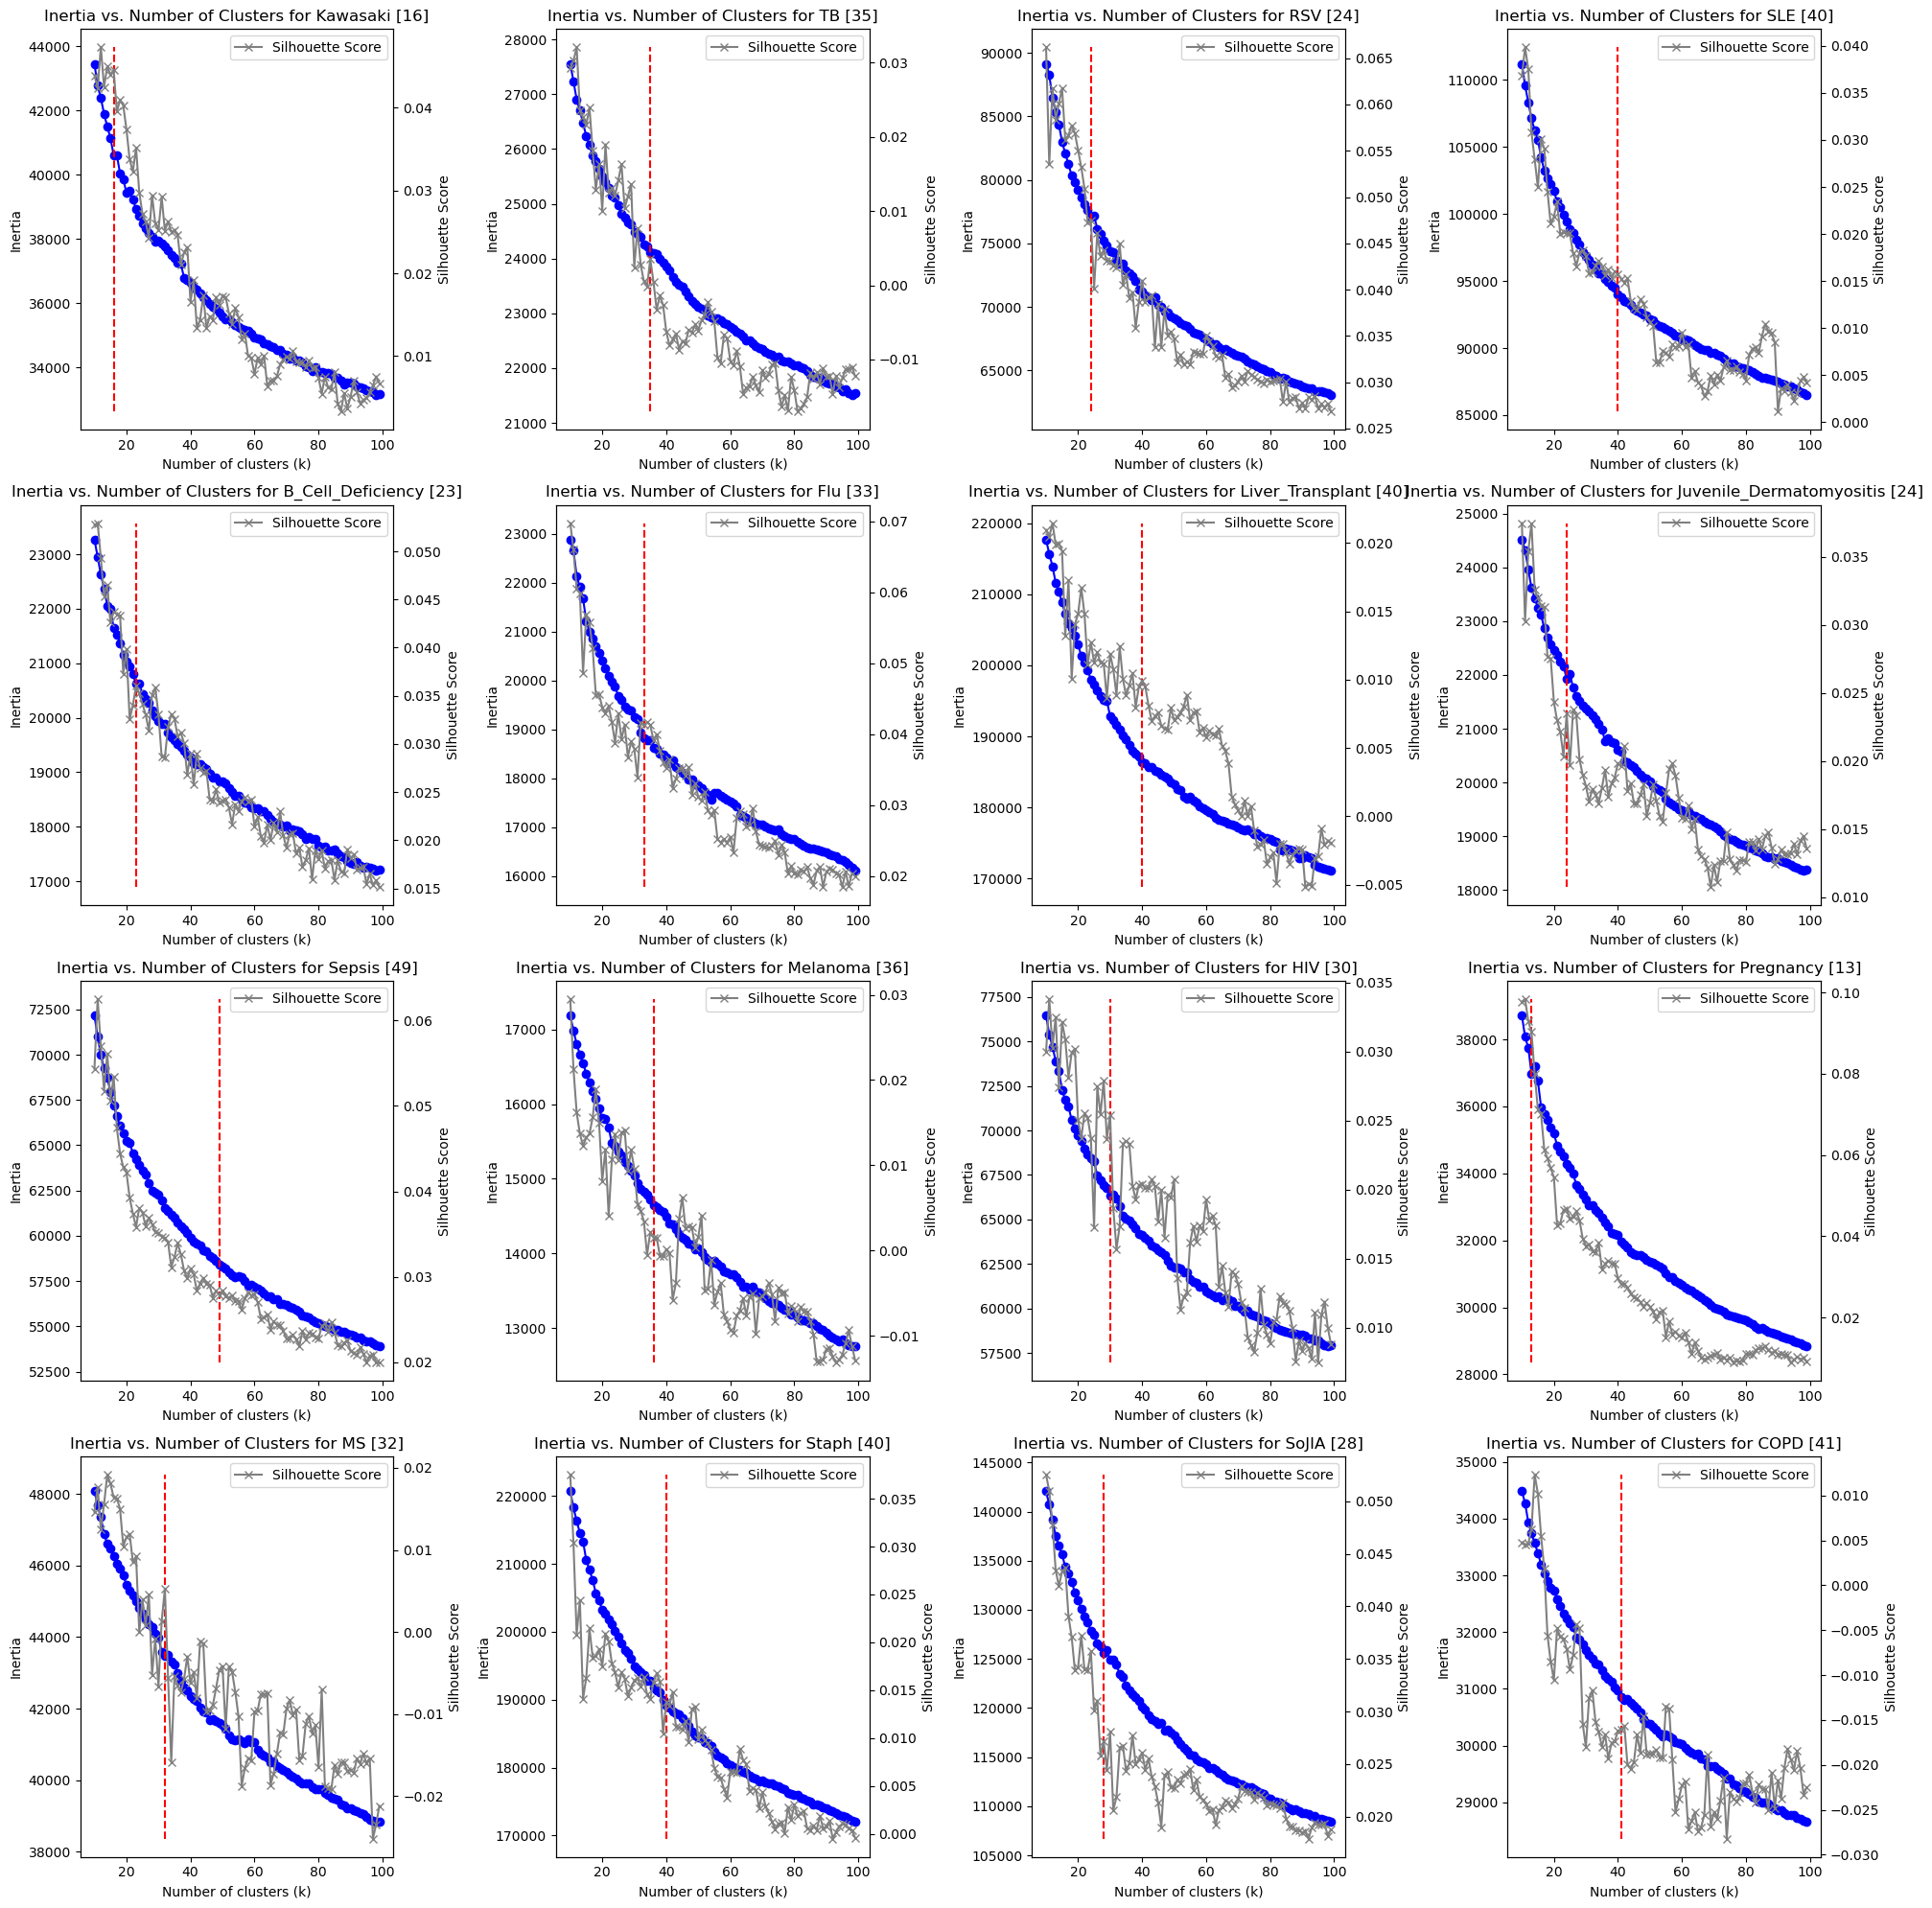

In [62]:
# Get unique disease types
disease_types = clusterEnergy_samples['disease_type'].unique()

# Create subplots with 4 by 4 grid
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

optimalK_inertia = {}
optimalK_silhouette = {}
optimalK = {}

# Plot each disease type in a separate subplot
for ax, disease in zip(axes, disease_types):
    data = clusterEnergy_samples[clusterEnergy_samples['disease_type'] == disease]
    # get elbow point
    kneedle = KneeLocator(data.k, data.inertia, curve='convex', direction='decreasing',S=1)
    elbow_point = kneedle.elbow

    
    ax.plot(data['k'], data['inertia'], 'o-',color='blue', label='Inertia')
    ax.vlines(elbow_point, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dashed',label='Elbow Point [Inertia]', color='red')
    ax.set_title(f'Inertia vs. Number of Clusters for {disease} [{elbow_point}]',fontdict={'fontsize': 12, 'fontweight': 'medium'})
    ax.set_xlabel('Number of clusters (k)')
    ax.set_ylabel('Inertia')

    # Add silhouette score to the same plot
    ax2 = ax.twinx()
    ax2.plot(data['k'], data['silhouette_score'], 'x-', color='gray', label='Silhouette Score')
    #
    ax2.set_ylabel('Silhouette Score')
    ax2.legend(loc='upper right')
    optimalK[disease] = elbow_point

# Remove any unused subplots
for i in range(len(disease_types), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [63]:
optimalK

{'Kawasaki': 16,
 'TB': 35,
 'RSV': 24,
 'SLE': 40,
 'B_Cell_Deficiency': 23,
 'Flu': 33,
 'Liver_Transplant': 40,
 'Juvenile_Dermatomyositis': 24,
 'Sepsis': 49,
 'Melanoma': 36,
 'HIV': 30,
 'Pregnancy': 13,
 'MS': 32,
 'Staph': 40,
 'SoJIA': 28,
 'COPD': 41}

### Check integrity of cluster

**Pearson Correlation Check**

After clustering, we evaluate the internal coherence of each cluster by calculating the Pearson correlation between each probe in the cluster and the mean expression profile (the centroid) of that cluster.

For each probe, the Pearson correlation measures how similar its expression pattern is to the average expression pattern of the cluster. If the average Pearson correlation of the cluster is below the threshold (in this case, 0.3), the cluster is flagged as invalid and added to the rejected_clusters list.

If the average Pearson correlation is above the threshold, the cluster is considered valid and added to the valid_clusters list.

In [64]:
# optimalK = {'Juvenile_Dermatomyositis': 57,
#  'Melanoma': 27,
#  'Pregnancy': 42,
#  'Staph': 55,
#  'B_Cell_Deficiency': 52,
#  'SLE': 44,
#  'Liver_Transplant': 35,
#  'SoJIA': 48,
#  'Kawasaki': 54,
#  'COPD': 49,
#  'Sepsis': 54,
#  'MS': 40,
#  'RSV': 59,
#  'TB': 50,
#  'HIV': 44,
#  'Flu': 44}

In [81]:
def validate_kmeans(data, kmeans, correlation_threshold=0.3):
    # Retrieve the cluster centroids
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    clustersize = len(np.unique(labels))
    # Step 2: Check Pearson correlation for each cluster
    is_valid_k = True
    cluster_sanity = {}
    for cluster in np.unique(labels):
        # Get the indices of the probes in this cluster
        cluster_indices = np.where(labels == cluster)[0]  # Assuming labels is the output of kmeans.labels_
        cluster_data = data[cluster_indices]
        
        # Calculate the mean expression profile (centroid) for the cluster
        mean_vector = centroids[cluster]
        
        # Calculate Pearson correlation for each probe in the cluster
        correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]
        avg_correlation = np.mean(correlations)
        
        # If the average correlation for this cluster is below the threshold, reject k
        if avg_correlation <= correlation_threshold:
            print(f"Cluster {cluster} rejected at k<={clustersize} due to low average correlation ({avg_correlation:.2f}). Restarting with k={clustersize-1}")
            is_valid_k = False
            cluster_sanity[cluster] = avg_correlation
            # break  # No need to check further clusters at this k
        else:
            cluster_sanity[cluster] = avg_correlation
    return cluster_sanity,is_valid


### Validate cluster and generate co-clustering matrix 

In [85]:


coclusteringDF = pd.DataFrame()
cluster_sanity = {}
consistent_cluster = {}
for k in optimalK.keys():
    print (f"current optimal cluster for {k} :{optimalK[k]}")
    dmat = processed_files[k]
    # do Kmeans clustering with optimal K with a range of +20 and -20
    prev_optK = optimalK[k]
    optimal_cluster = prev_optK
    for i in range(prev_optK+60,prev_optK-50, -1):
        km = KMeans(n_clusters=i, random_state=1, max_iter=100,init='k-means++').fit(dmat)
        labels = km.labels_
        centroids = km.cluster_centers_

        # Validate the clustering
        cluster_sanity_tmp, is_valid_tmp = validate_kmeans(dmat.values, km, correlation_threshold=0.3)
        if is_valid_tmp:
            optimal_cluster = i
            print (f"Optimal cluster found for {k}: {optimal_cluster}")
            break
    

    km = KMeans(n_clusters=optimalK[k], random_state=1, max_iter=100,init='k-means++').fit(dmat)
    labels = km.labels_
    centroids = km.cluster_centers_

    # Validate the clustering
    cs_final, is_valid = validate_kmeans(dmat.values, km, correlation_threshold=0.3)
    if is_valid:
        print (f"Final optimal cluster found for {k}: {optimal_cluster}")
        consistent_cluster[k] = optimal_cluster
    else:
        print (f"[Retaining old] Final optimal cluster not found for {k}: {optimal_cluster}")
        consistent_cluster[k] = prev_optK
    cluster_sanity[k] = cs_final

    tmp = pd.DataFrame(km.labels_,index=dmat.index,columns=[k])
    coclusteringDF = pd.concat([coclusteringDF,tmp],axis=1)
    # break


current optimal cluster for Kawasaki :16
Optimal cluster found for Kawasaki: 76
Final optimal cluster found for Kawasaki: 76
current optimal cluster for TB :35
Optimal cluster found for TB: 95
Final optimal cluster found for TB: 95
current optimal cluster for RSV :24
Cluster 8 rejected at k<=84 due to low average correlation (0.27). Restarting with k=83
Optimal cluster found for RSV: 84
Final optimal cluster found for RSV: 84
current optimal cluster for SLE :40
Optimal cluster found for SLE: 100
Cluster 24 rejected at k<=40 due to low average correlation (0.19). Restarting with k=39
Final optimal cluster found for SLE: 100
current optimal cluster for B_Cell_Deficiency :23
Optimal cluster found for B_Cell_Deficiency: 83
Final optimal cluster found for B_Cell_Deficiency: 83
current optimal cluster for Flu :33
Optimal cluster found for Flu: 93
Final optimal cluster found for Flu: 93
current optimal cluster for Liver_Transplant :40
Cluster 29 rejected at k<=100 due to low average correlati

In [86]:
cluster_sanity.keys()

dict_keys(['Kawasaki', 'TB', 'RSV', 'SLE', 'B_Cell_Deficiency', 'Flu', 'Liver_Transplant', 'Juvenile_Dermatomyositis', 'Sepsis', 'Melanoma', 'HIV', 'Pregnancy', 'MS', 'Staph', 'SoJIA', 'COPD'])

In [87]:
clusterSanity_df = pd.DataFrame(cluster_sanity)

In [88]:
cluster_sanity

{'Kawasaki': {0: 0.36616699504418193,
  1: 0.7751696079020223,
  2: 0.7209860609175343,
  3: 0.6870578990073469,
  4: 0.7175451138179252,
  5: 0.647511210183772,
  6: 0.6405189741963139,
  7: 0.5602082660032512,
  8: 0.6000946220101067,
  9: 0.635121187536924,
  10: 0.7797204452134489,
  11: 0.4650513241850926,
  12: 0.48340472017733793,
  13: 0.6366910963994445,
  14: 0.7013072888012609,
  15: 0.7134045990228047},
 'TB': {0: 0.682219933251757,
  1: 0.4257502430884345,
  2: 0.5827333878459872,
  3: 0.9335886143025172,
  4: 0.6275362706035897,
  5: 0.708145657620176,
  6: 0.6262697293235628,
  7: 0.7229790347916888,
  8: 0.525089373177812,
  9: 0.41472314284650724,
  10: 0.6664167093355576,
  11: 0.6668006538666089,
  12: 0.6196222334386355,
  13: 0.6032936031417648,
  14: 0.4948619452382209,
  15: 0.6887144771597727,
  16: 0.6813933429421695,
  17: 0.8193634492123948,
  18: 0.48456078904758143,
  19: 0.512774761676549,
  20: 0.8879685236396762,
  21: 0.7164219930336854,
  22: 0.4042352

In [89]:
clusterSanity_df

,Kawasaki,TB,RSV,SLE,B_Cell_Deficiency,Flu,Liver_Transplant,Juvenile_Dermatomyositis,Sepsis,Melanoma,HIV,Pregnancy,MS,Staph,SoJIA,COPD
0,0.366167,0.682220,0.779643,0.834251,0.670137,0.501289,0.504145,0.579664,0.745822,0.656661,0.680434,0.692693,0.623673,0.713635,0.554368,0.662972
1,0.775170,0.425750,0.477701,0.453994,0.678181,0.393519,0.570338,0.467125,0.722159,0.601320,0.530118,0.770763,0.561209,0.600291,0.769860,0.356809
2,0.720986,0.582733,0.585823,0.634135,0.437980,0.781201,0.558919,0.688977,0.796533,0.604977,0.487544,0.751515,0.630052,0.440645,0.566872,0.531994
3,0.687058,0.933589,0.543173,0.475614,0.666396,0.737212,0.405612,0.707232,0.435743,0.500255,0.590222,0.821772,0.436182,0.646439,0.684270,0.666622
4,0.717545,0.627536,0.802875,0.608967,0.741696,0.660243,0.429497,0.520931,0.624190,0.901827,0.551656,0.806718,0.775009,0.954307,0.283712,0.475463
5,0.647511,0.708146,0.613967,0.490702,0.748665,0.530952,0.673818,0.625587,0.672128,0.732409,0.816349,0.551944,0.577478,0.507634,0.817045,0.509021
6,0.640519,0.626270,0.629860,0.626498,0.514858,0.725520,0.529991,0.586566,0.556277,0.685816,0.693220,0.909341,0.428434,0.703599,0.745516,0.465122
7,0.560208,0.722979,0.749016,0.845812,0.660400,0.628946,0.643167,0.504250,0.820699,0.692134,0.537837,0.732802,1.000000,0.616155,0.637512,0.428056
8,0.600095,0.525089,0.651178,0.589051,0.762086,0.785665,0.648526,0.462616,0.906717,0.494620,0.903237,0.673150,0.654390,0.655043,0.781004,0.492456
9,0.635121,0.414723,0.878108,0.639807,0.722946,0.785994,0.650752,0.763108,0.313082,0.912937,0.451016,0.819796,0.665630,0.610376,0.585026,0.642164


<Axes: >

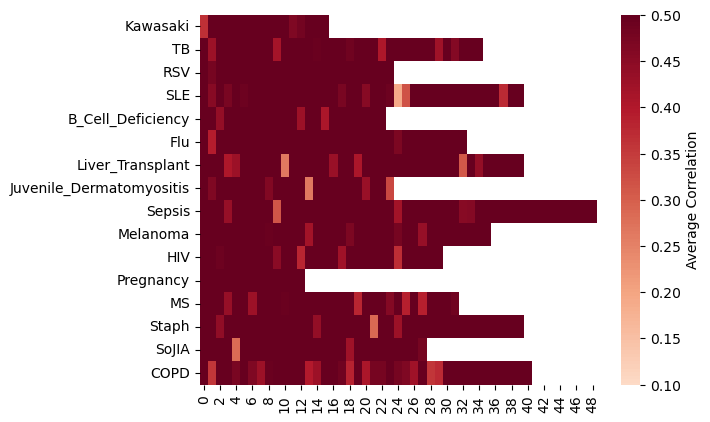

In [90]:
sns.heatmap(clusterSanity_df.T,  cmap='RdBu_r', center=0, cbar_kws={'label': 'Average Correlation'},vmin=0.1,vmax=0.5)

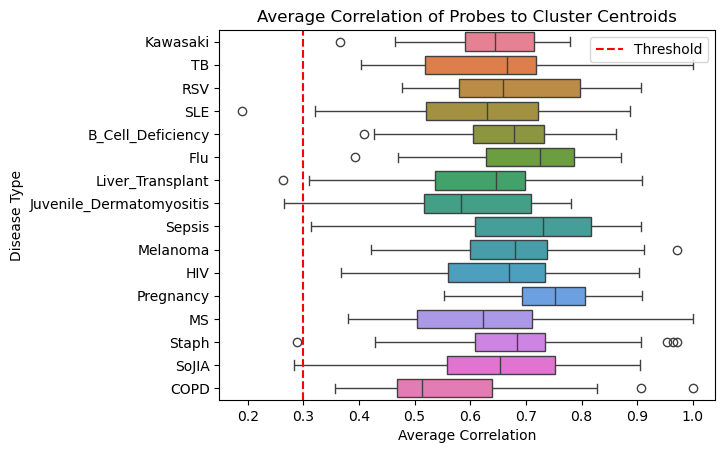

In [91]:
sns.boxplot(data=clusterSanity_df, orient='h')

plt.title('Average Correlation of Probes to Cluster Centroids')
plt.xlabel('Average Correlation')
plt.ylabel('Disease Type')
plt.axvline(x=0.3, color='red', linestyle='--', label='Threshold')
plt.legend()

### Clustering approch 2:
Instead of directly relying on Hartigan’s K-Means to iteratively reduce k and restart the clustering process, you can combine it with a more reliable method for determining the optimal number of clusters before starting the iterative refinement process.

Here’s how we can modify the approach:

1. Stage 1: Use the Elbow Method or Silhouette Score to Preselect an Optimal Range of Clusters:

Rather than starting with a very high number of clusters (e.g., 100), use the Elbow Method or Silhouette Score to preselect a reasonable range of clusters where the data exhibits natural clustering patterns.
This will ensure that you start with a meaningful k and avoid wasting time on overly high k values that are likely to lead to singleton clusters.

2. Stage 2: Apply Hartigan’s K-Means with a Reasonable Range of k:

After identifying a suitable range for k (say, between 10 and 30, depending on the results of Stage 1), apply Hartigan’s K-Means with the Pearson correlation threshold check, starting from the higher end of this range. This will reduce the chances of failure to converge.

In [92]:
import sklearn.metrics as metrics
def optimal_k_elbow_silhouette(data, k_min=2, k_max=30):
    """
    Use the Elbow method and Silhouette Score to find the optimal range of k for clustering.
    
    Parameters:
    - data: np.ndarray, rows are probes and columns are samples.
    - k_min: int, minimum number of clusters to test.
    - k_max: int, maximum number of clusters to test.
    
    Returns:
    - optimal_k: int, the best number of clusters based on the Elbow method and Silhouette score.
    """
    best_k = k_min
    best_silhouette = -1  # Lower bound for silhouette score
    
    for k in range(k_min, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        #  metrics.silhouette_score(dmatrix, km.labels_, metric='euclidean')
        silhouette_avg = metrics.silhouette_score(data, labels)
        
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_k = k
    
    return best_k

def hartigan_kmeans_with_optimal_range(data, correlation_threshold=0.3, k_min=2, k_max=30):
    """
    Perform Hartigan's K-Means within a selected range of k.
    Use Pearson correlation check to validate clusters.
    
    Parameters:
    - data: np.ndarray, rows are probes and columns are samples.
    - correlation_threshold: float, threshold for Pearson correlation.
    - k_min: int, minimum number of clusters to test.
    - k_max: int, maximum number of clusters to test.
    
    Returns:
    - labels: np.ndarray, final cluster labels.
    - best_k: int, the number of clusters that passed the Pearson correlation check.
    """
    # Stage 1: Use Elbow Method or Silhouette to pre-select a reasonable range for k
    optimal_k = optimal_k_elbow_silhouette(data, k_min=k_min, k_max=k_max)
    print(f"Optimal range for k identified: {optimal_k}")
    
    # Stage 2: Apply Hartigan's K-Means starting from optimal_k
    for k in range(optimal_k, k_min - 1, -1):
        print(f"Clustering with k = {k} clusters...")
        
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        centroids = kmeans.cluster_centers_
        
        is_valid_k = True
        for cluster in range(k):
            cluster_indices = np.where(labels == cluster)[0]
            cluster_data = data[cluster_indices]
            
            mean_vector = centroids[cluster]
            correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]
            avg_correlation = np.mean(correlations)
            
            if avg_correlation < correlation_threshold:
                print(f"Cluster {cluster} rejected at k={k} due to low average correlation ({avg_correlation:.2f}).")
                is_valid_k = False
                break  # Restart with k-1
        
        if is_valid_k:
            print(f"Valid clustering found with k = {k}")
            return labels, k

    print("No valid clustering found within the given range.")
    return None, None

# # Example usage
# data = np.random.rand(100, 5)  # Example data
# labels, best_k = hartigan_kmeans_with_optimal_range(data, correlation_threshold=0.3)

In [93]:
processed_files['RSV'].shape

(7172, 84)

In [94]:
optimal_k = optimal_k_elbow_silhouette(processed_files['RSV'], k_min=30, k_max=100)
print(f"Optimal range for k identified: {optimal_k}")

Optimal range for k identified: 31


In [29]:
optimal_k = optimal_k_elbow_silhouette(processed_files['HIV'], k_min=20, k_max=100)
print(f"Optimal range for k identified: {optimal_k}")

Optimal range for k identified: 27


In [431]:
coclusteringDF.head()

,MS,COPD,SLE,Kawasaki,Melanoma,Flu,B_Cell_Deficiency,Pregnancy,Liver_Transplant,Juvenile_Dermatomyositis,HIV,Sepsis,Staph,SoJIA,RSV,TB
ID_REF,,,,,,,,,,,,,,,,
ILMN_1658420,20.0,5.0,30.0,1.0,34.0,11.0,20.0,8.0,27.0,22.0,4.0,20.0,1.0,0.0,44.0,27.0
ILMN_2387224,27.0,22.0,40.0,23.0,3.0,22.0,1.0,9.0,44.0,3.0,44.0,29.0,1.0,0.0,44.0,26.0
ILMN_1870248,10.0,9.0,1.0,1.0,34.0,22.0,1.0,1.0,27.0,20.0,4.0,20.0,1.0,2.0,31.0,15.0
ILMN_1903345,18.0,3.0,1.0,1.0,18.0,11.0,25.0,36.0,27.0,20.0,24.0,20.0,1.0,0.0,31.0,44.0
ILMN_1884723,18.0,0.0,1.0,22.0,32.0,11.0,20.0,22.0,37.0,18.0,4.0,20.0,39.0,1.0,31.0,27.0


# Making co-clustering Matrix 

It sounds like you’ve already taken important steps in building the co-clustering similarity matrix, using the Hamming distance to measure how often two probes are assigned to the same cluster across multiple disease types. This is a solid approach for generating the probe × probe similarity matrix.

Here’s a more detailed breakdown of your process and how you can proceed to build the network and extract modules:

1. Hamming Distance-Based Similarity Matrix
You used Hamming distance to calculate how often two probes share the same cluster across different disease types. This is a natural fit because it counts the proportion of times two elements differ.

Here’s a breakdown of your process:

Hamming Distance Calculation: The Hamming distance counts the number of mismatches (i.e., how many times two probes are in different clusters across diseases).
Conversion to Similarity Matrix: You converted the Hamming distance into a similarity score by subtracting the Hamming distance from the total number of datasets (i.e., disease types).
This can be summarized as:

`Similarity(𝑖,𝑗)=number of datasets−(Hamming distance between probes 𝑖 and 𝑗)`

This similarity matrix can now be used to build a network.

2. Building the Network from the Similarity Matrix
Now that you have a similarity matrix, the next step is to build a graph where nodes represent probes, and edges represent the strength of co-clustering (based on the similarity score). You can threshold the similarity matrix to filter out weak connections, i.e., only keeping edges where probes co-cluster above a certain level across diseases.



In [95]:
dist_matrix = squareform(pdist(coclusteringDF,"hamming"))
# generate similarity matric from  distance based on number of dataset used for the co-clustering matrix
dist_matrix = coclusteringDF.shape[1] - dist_matrix*coclusteringDF.shape[1]


# dataframe from distance matrix
dist_matrixDF = pd.DataFrame(dist_matrix,index=coclusteringDF.index, columns=coclusteringDF.index)
dist_matrixDF_frac = dist_matrixDF/coclusteringDF.shape[1]

dist_matrixDF_frac.index = dist_matrixDF_frac.index.astype(str)
dist_matrixDF_frac.index.name = 'g1'
dist_matrixDF_frac.columns.name = 'g2'
dist_matrixDF_frac

g2,ILMN_1658420,ILMN_1863592,ILMN_1795609,ILMN_1723935,ILMN_1709440,ILMN_1727091,ILMN_1813650,ILMN_1655485,ILMN_1723287,ILMN_1786275,...,ILMN_1909149,ILMN_1880493,ILMN_2064694,ILMN_1802550,ILMN_1756657,ILMN_1787347,ILMN_1706817,ILMN_1779256,ILMN_1723486,ILMN_2348050
g1,,,,,,,,,,,,,,,,,,,,,
ILMN_1658420,1.0000,0.0000,0.3125,0.7500,0.625,0.3125,0.6250,0.0000,0.0000,0.0625,...,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0625,0.0,0.0
ILMN_1863592,0.0000,1.0000,0.0000,0.0625,0.125,0.1875,0.0625,0.0000,0.0625,0.1875,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0
ILMN_1795609,0.3125,0.0000,1.0000,0.3125,0.375,0.3750,0.2500,0.1250,0.0000,0.1875,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0
ILMN_1723935,0.7500,0.0625,0.3125,1.0000,0.750,0.3750,0.6250,0.0000,0.0000,0.0625,...,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0625,0.0,0.0
ILMN_1709440,0.6250,0.1250,0.3750,0.7500,1.000,0.4375,0.7500,0.0000,0.0625,0.0625,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ILMN_1787347,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0000,1.0,0.0,0.0000,0.0,0.0
ILMN_1706817,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0000,0.0,1.0,0.0000,0.0,0.0
ILMN_1779256,0.0625,0.0000,0.0000,0.0625,0.000,0.0000,0.0625,0.0000,0.0000,0.0000,...,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,1.0000,0.0,0.0


# Chekpoint validation

In [96]:
bg3_pub = pd.read_excel("../data/pubdata/41467_2021_24584_MOESM4_ESM.xlsx",sheet_name="Supplementary_Table_vDEC2019")
bg3_pubDF = []#pd.DataFrame(columns=['ID','Genes','Probes'])
for k in bg3_pub.index:
    m_name = bg3_pub.loc[k,'ID']
    genes = bg3_pub.loc[k,'Member genes'].split(",")
    probes = bg3_pub.loc[k,'Module Probe IDs'].split(",")
    for p,g in zip(probes,genes):
        bg3_pubDF.append([m_name,g,p,bg3_pub.loc[k,'Module title']])
bg3_pubDF = pd.DataFrame(bg3_pubDF,columns=['ID','Genes','Probes','modtitle'])
bg3_pubDF['Probes'] = bg3_pubDF['Probes'].str.strip()
bg3_pubDF['Genes'] = bg3_pubDF['Genes'].str.strip()
bg3_pubDF['ID'] = bg3_pubDF['ID'].str.strip()


bg3_pubDF['outerloop'] = bg3_pubDF['ID'].str.split(".").str[0].str[1:]
bg3_pubDF['innerloop'] = bg3_pubDF['ID'].str.split(".").str[1]
bg3_pubDF['outerloop'] = bg3_pubDF['outerloop'].astype(int)
bg3_pubDF['innerloop'] = bg3_pubDF['innerloop'].astype(int)

bg3_pubDF.sort_values(by=['outerloop','innerloop'],inplace=True)
bg3_pubDF.head()

,ID,Genes,Probes,modtitle,outerloop,innerloop
0,M3.1,ALPP,1693789,Cell cycle,3,1
1,M3.1,ALS2CR14,1787314,Cell cycle,3,1
2,M3.1,ANKRD30B,1730678,Cell cycle,3,1
3,M3.1,ARL16,2188119,Cell cycle,3,1
4,M3.1,BCYRN1,1678757,Cell cycle,3,1


In [98]:
print ("Total unique genes in the dataset: ", bg3_pubDF.Probes.nunique())

Total unique genes in the dataset:  14504


## Checkpoint

In [41]:
dist_matrixDF_frac.to_csv("../ckpnt/coclustering_distMatrix.csv")

In [71]:
coclusteringDF.head()

,Kawasaki
g2,
ILMN_1658420,1
ILMN_1863592,12
ILMN_1795609,11
ILMN_1723935,1
ILMN_1709440,12


### Reading from chekpoint of coclustering matrix

In [100]:
# dist_matrixDF_frac = pd.read_csv("../ckpnt/coclustering_distMatrix.csv",index_col=0)
# dist_matrixDF_frac.head()
dist_matrixDF_frac.columns.name = 'g2'
dist_matrixDF_frac.index.name = 'g1'
dist_matrixDF_frac.head()

g2,ILMN_1658420,ILMN_1863592,ILMN_1795609,ILMN_1723935,ILMN_1709440,ILMN_1727091,ILMN_1813650,ILMN_1655485,ILMN_1723287,ILMN_1786275,...,ILMN_1909149,ILMN_1880493,ILMN_2064694,ILMN_1802550,ILMN_1756657,ILMN_1787347,ILMN_1706817,ILMN_1779256,ILMN_1723486,ILMN_2348050
g1,,,,,,,,,,,,,,,,,,,,,
ILMN_1658420,1.0000,0.0000,0.3125,0.7500,0.625,0.3125,0.6250,0.000,0.0000,0.0625,...,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0625,0.0,0.0
ILMN_1863592,0.0000,1.0000,0.0000,0.0625,0.125,0.1875,0.0625,0.000,0.0625,0.1875,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0
ILMN_1795609,0.3125,0.0000,1.0000,0.3125,0.375,0.3750,0.2500,0.125,0.0000,0.1875,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0
ILMN_1723935,0.7500,0.0625,0.3125,1.0000,0.750,0.3750,0.6250,0.000,0.0000,0.0625,...,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0625,0.0,0.0
ILMN_1709440,0.6250,0.1250,0.3750,0.7500,1.000,0.4375,0.7500,0.000,0.0625,0.0625,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0


# Building network and module harvesting

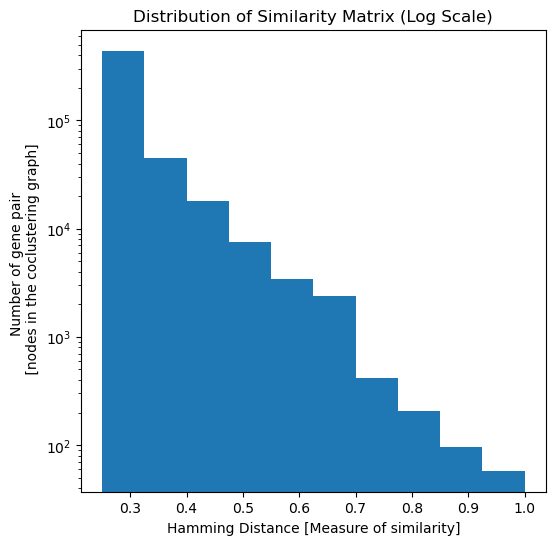

In [101]:

# condense dataframe using upper triangle of the square matrix without diagonal
keep = np.triu(np.ones(dist_matrixDF_frac.shape),k=1).astype('bool').reshape(dist_matrixDF_frac.size)
dmatDF = dist_matrixDF_frac.unstack()[keep].reset_index().rename({0:'HmmingDist'},axis=1)
dmatDF_nz = dmatDF[dmatDF.HmmingDist!=0].reset_index().drop('index',axis=1)

# plot showing distribution of similarity matrix in log scale as subplot
fig, ax = plt.subplots(figsize=(6, 6))
dmatDF_nz[dmatDF_nz.HmmingDist > 0.2].HmmingDist.plot(kind="hist", ax=ax, logy=True)
ax.set_xlabel("Hamming Distance [Measure of similarity]")
ax.set_ylabel("Number of gene pair \n [nodes in the coclustering graph]")
ax.set_title("Distribution of Similarity Matrix (Log Scale)")
plt.show()

## Approach 1: Module extraction  using Louvain community detection and filtering by minimum clique size and minimum module size. 
The approach works by iterating through a range of similarity thresholds and identifying cliques or communities at each step.

Here’s an explanation of what the code does:

Key Steps in the Code:
**Iterating Over Similarity Thresholds:**

You’re looping from the number of datasets (numDataset) down to 1, adjusting the similarity threshold for each iteration. The variable i is used to calculate upper (ul) and lower (ll) limits for the similarity range.
For each iteration, the rows of the dataframe (dmatDF_nz_probeFinding) are filtered to keep only probe pairs that co-cluster with a Hamming distance greater than or equal to the lower limit.
**Community Detection Using Louvain:**

Once the filtered subset of probe pairs (dx) is determined, you build a graph from it using networkx. The graph contains edges between probes where the edge weights are based on Hamming distance (i.e., the strength of co-clustering).
You then apply the Louvain community detection algorithm to find communities (potential modules) in the graph, which is faster than exhaustive clique detection.

**Filtering by Minimum Module Size:**

After identifying the communities (or cliques), you filter them to retain only those that have at least min_module_size members (e.g., 15 genes).
The selected communities are added to the moduleMT_comm dictionary, which stores each module and its corresponding gene set.
**Removing Identified Genes:**

After extracting modules, the genes found in these modules are removed from the dataframe dmatDF_nz_probeFinding to avoid re-clustering them in the next iteration.
This ensures that each gene is only assigned to one module.
**Aggregation and Module Naming:**

Modules are named sequentially using L1, M1.1, M1.2, etc., indicating the hierarchy of aggregates and modules.


In [5]:
import networkx as nx
from networkx.algorithms.community import k_clique_communities

In [33]:
## extract clicques
min_clique_size = 3 # The size of the cliques to consider
min_module_size = 15 # minium size of a module 
# 
moduleMT_comm = {}
agg_number = 0
dmatDF_nz_probeFinding = dmatDF_nz.copy()
numDataset = coclusteringDF.shape[1] # number of dataset in the study

print ("Extracting modules")
for i in np.arange(numDataset,1,-1):
    ul =  i/numDataset
    ll = (i-1)/numDataset
    dx = dmatDF_nz_probeFinding[dmatDF_nz_probeFinding.HmmingDist>=ll]

    print ("threshold", ul, ll, dx.shape, dx.g1.nunique(), dx.g2.nunique())
    # check the selection has enough number of genes
    genes_aggregates = []
    if dx.g1.nunique() >= min_module_size:
        print ("Searching commnity cliques at similarity",i, i-1)
        agg_number += 1
        aggregateName = "L{}".format(agg_number)
        # module initial "M1."
        modInitial = "M{}".format(agg_number)
        moduleMT_comm[aggregateName] = {}
        g = nx.from_pandas_edgelist(dx,source='g1',target='g2', edge_attr='HmmingDist')
        # clique_neighborhoods = list(k_clique_communities(g, min_clique_size))
        # this is way faster
        clique_neighborhoods = nx.community.louvain_communities(g, weight="HmmingDist")
        print ("clique found:", len(clique_neighborhoods))
        modulenumber = 1
        geneMembers = []
        for cn in tqdm(clique_neighborhoods):
            if len(cn) >= min_module_size:
                modNumber = "{}.{}".format(modInitial, modulenumber)
                moduleMT_comm[aggregateName][modNumber] = cn
                modulenumber += 1
                geneMembers.extend(cn)
            else:
                pass
        genes_aggregates.extend(geneMembers)
        print ("Modules count in aggregate {} = {}".format(aggregateName,len(list(moduleMT_comm[aggregateName].keys()))))
    else:
        print ("!! No clique with min module size")
        
    dmatDF_nz_probeFinding = dmatDF_nz_probeFinding[(~dmatDF_nz_probeFinding.g1.isin(genes_aggregates))&(~dmatDF_nz_probeFinding.g2.isin(genes_aggregates))]
    print (len(genes_aggregates),"genes removed from matrix,", dmatDF_nz_probeFinding.shape, dmatDF_nz_probeFinding.g1.nunique())

Extracting modules
threshold 1.0 0.9375 (1, 3) 1 1
!! No clique with min module size
0 genes removed from matrix, (12525271, 3) 12668
threshold 0.9375 0.875 (18, 3) 14 16
!! No clique with min module size
0 genes removed from matrix, (12525271, 3) 12668
threshold 0.875 0.8125 (65, 3) 37 31
Searching commnity cliques at similarity 14 13
clique found: 15


100%|██████████| 15/15 [00:00<00:00, 228780.22it/s]

Modules count in aggregate L1 = 0


0 genes removed from matrix, (12525271, 3) 12668
threshold 0.8125 0.75 (194, 3) 73 76
Searching commnity cliques at similarity 13 12
clique found: 26


100%|██████████| 26/26 [00:00<00:00, 300418.47it/s]

Modules count in aggregate L2 = 1


20 genes removed from matrix, (12508004, 3) 12648
threshold 0.75 0.6875 (260, 3) 116 113
Searching commnity cliques at similarity 12 11
clique found: 49


100%|██████████| 49/49 [00:00<00:00, 699050.67it/s]

Modules count in aggregate L3 = 2


32 genes removed from matrix, (12451008, 3) 12616
threshold 0.6875 0.625 (383, 3) 210 202
Searching commnity cliques at similarity 11 10
clique found: 101


100%|██████████| 101/101 [00:00<00:00, 1075189.60it/s]

Modules count in aggregate L4 = 4


80 genes removed from matrix, (12336119, 3) 12536
threshold 0.625 0.5625 (665, 3) 406 389
Searching commnity cliques at similarity 10 9
clique found: 185


100%|██████████| 185/185 [00:00<00:00, 1418548.88it/s]

Modules count in aggregate L5 = 8


177 genes removed from matrix, (11990716, 3) 12359
threshold 0.5625 0.5 (1370, 3) 861 827
Searching commnity cliques at similarity 9 8
clique found: 336


100%|██████████| 336/336 [00:00<00:00, 1739859.44it/s]

Modules count in aggregate L6 = 18


523 genes removed from matrix, (10670815, 3) 11836
threshold 0.5 0.4375 (2813, 3) 1620 1553
Searching commnity cliques at similarity 8 7
clique found: 345


100%|██████████| 345/345 [00:00<00:00, 1537762.89it/s]

Modules count in aggregate L7 = 32


1701 genes removed from matrix, (6226413, 3) 10135
threshold 0.4375 0.375 (2562, 3) 1586 1499
Searching commnity cliques at similarity 7 6
clique found: 305


100%|██████████| 305/305 [00:00<00:00, 987847.66it/s]

Modules count in aggregate L8 = 36


1694 genes removed from matrix, (3222138, 3) 8441
threshold 0.375 0.3125 (2699, 3) 1563 1440
Searching commnity cliques at similarity 6 5
clique found: 191


100%|██████████| 191/191 [00:00<00:00, 752924.87it/s]

Modules count in aggregate L9 = 32


1818 genes removed from matrix, (1173347, 3) 6621
threshold 0.3125 0.25 (2009, 3) 1181 1032
Searching commnity cliques at similarity 5 4
clique found: 166


100%|██████████| 166/166 [00:00<00:00, 347259.08it/s]

Modules count in aggregate L10 = 31
1321 genes removed from matrix, (468038, 3) 5296
threshold 0.25 0.1875 (2585, 3) 1259 1063
Searching commnity cliques at similarity 4 3


clique found: 115


100%|██████████| 115/115 [00:00<00:00, 269015.59it/s]


Modules count in aggregate L11 = 25
1415 genes removed from matrix, (129219, 3) 3869
threshold 0.1875 0.125 (3818, 3) 1399 1156
Searching commnity cliques at similarity 3 2
clique found: 124


100%|██████████| 124/124 [00:00<00:00, 487435.52it/s]

Modules count in aggregate L12 = 31
1498 genes removed from matrix, (24861, 3) 2314
threshold 0.125 0.0625 (24861, 3) 2314 2097
Searching commnity cliques at similarity 2 1


clique found: 36


100%|██████████| 36/36 [00:00<00:00, 267247.69it/s]

Modules count in aggregate L13 = 29
2347 genes removed from matrix, (35, 3) 14


In [34]:
modTrans = []
for k in moduleMT_comm.keys():
    if len(list(moduleMT_comm[k])):
        for m in moduleMT_comm[k].keys():
            for gene in moduleMT_comm[k][m]:
                modTrans.append([gene, m, k])
fix_bg3MT = pd.DataFrame(modTrans,columns=['gene','moduleID','Loop'])
print (fix_bg3MT.gene.nunique(),fix_bg3MT.moduleID.nunique(), fix_bg3MT.Loop.nunique())

12626 249 12


## Approach 2:  Clique and Paraclique-Based Extraction
Steps:
* Co-Clustering Matrix: Same starting point as your method, using a matrix of probes vs. disease types with cluster assignments.
Similarity Matrix: Similar to your method, Hamming distance is used to measure the similarity between probes, i.e., how often they co-cluster.
* Clique Detection: Instead of using Louvain, we find maximum cliques in the similarity graph. A clique is a fully connected subgraph, meaning all genes in a clique co-cluster strongly across datasets.
* Paraclique Expansion: After detecting cliques, we expand them into paracliques by allowing probes that co-cluster with at least 90% of the clique members to join.
* Module Extraction: Each paraclique is treated as a biologically relevant module. Genes that have been assigned to a module are removed for the next iteration.

### Building the Co-Cluster Graph
The co-clustering matrix is a square matrix where each element represents the strength of co-clustering between two probes. We can use this matrix to build an unweighted graph, where an edge exists between two probes if they co-cluster above a certain threshold.

In [102]:
# def build_co_cluster_graph(co_clustering_matrix, threshold):
#     """
#     Build a co-cluster graph using the co-clustering matrix.
#     Nodes are probes, and edges are added if the co-clustering value exceeds the threshold.
    
#     Parameters:
#     - co_clustering_matrix: np.ndarray, square matrix where element (i, j) represents co-clustering between probe i and j.
#     - threshold: float, the minimum co-clustering score to consider an edge between two probes.
    
#     Returns:
#     - G: A NetworkX graph representing the co-cluster network.
#     """
#     dmat = co_clustering_matrix.values
#     n_probes = dmat.shape[0]
#     probel_list = co_clustering_matrix.index.tolist()  # Get the list of probes
#     # Create an empty graph
#     G = nx.Graph()
    
#     # Add edges between probes that co-cluster above the threshold
#     for i in range(n_probes):
#         for j in range(i+1, n_probes):
#             if co_clustering_matrix[i, j] >= threshold:
#                 g1 = probel_list[i]  
#                 g2 = probel_list[j]
#                 G.add_edge(g1, g2, weight=co_clustering_matrix[i, j])
    
#     return G

# # Example usage
# # co_clustering_matrix = np.random.rand(100, 100)  # Replace with your actual matrix
# threshold = 0.1  # Define an appropriate threshold for co-clustering
# G = build_co_cluster_graph(dist_matrixDF_frac, threshold)

G = nx.from_pandas_edgelist(dmatDF_nz,source='g1',target='g2', edge_attr='HmmingDist')

In [103]:

# Print the number of nodes and edges in the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# # Print basic statistics of the graph
# print(nx.classes.function.info(G))

# Calculate and print additional statistics
degree_sequence = [d for n, d in G.degree()]
print(f"Average degree: {sum(degree_sequence) / len(degree_sequence):.2f}")
print(f"Maximum degree: {max(degree_sequence)}")
print(f"Minimum degree: {min(degree_sequence)}")

Number of nodes: 12837
Number of edges: 14667685
Average degree: 2285.22
Maximum degree: 4987
Minimum degree: 10


### Generate test case by filtering graph for higher order similarity

In [72]:
import time

# Filter the dataframe to keep only edges with Hamming distance between 0.7 and 1
filtered_edges = dmatDF_nz[(dmatDF_nz['HmmingDist'] >= 0.1) & (dmatDF_nz['HmmingDist'] <= 1)]

# Start timing
start_time = time.time()

# Create a new graph with the filtered edges
filtered_G = nx.from_pandas_edgelist(filtered_edges, source='g1', target='g2', edge_attr='HmmingDist')

# End timing
end_time = time.time()

# Print the elapsed time
print(f"Time taken to create the filtered graph: {end_time - start_time:.2f} seconds")

# Print the number of nodes and edges in the filtered graph
print(f"Number of nodes in filtered graph: {filtered_G.number_of_nodes()}")
print(f"Number of edges in filtered graph: {filtered_G.number_of_edges()}")

Time taken to create the filtered graph: 7.78 seconds
Number of nodes in filtered graph: 11031
Number of edges in filtered graph: 3279325


In [89]:
number_of_dataset =16
min_dataset = 0
for i in range(number_of_dataset,min_dataset,-1):
    print (i, i/number_of_dataset)

16 1.0
15 0.9375
14 0.875
13 0.8125
12 0.75
11 0.6875
10 0.625
9 0.5625
8 0.5
7 0.4375
6 0.375
5 0.3125
4 0.25
3 0.1875
2 0.125
1 0.0625


### Finding Maximum Cliques for filtered graph of minium clique size of 3
Once we have the graph, we can find maximum cliques, which are sets of fully interconnected nodes (probes). This is done using NetworkX's find_cliques function, which finds all cliques, including the maximum ones.

In [15]:
def filter_graph_by_degree(graph, min_degree):
    """
    Filter the graph to only include nodes with at least `min_degree` connections.
    
    Parameters:
    - graph: A NetworkX graph.
    - min_degree: int, minimum number of connections a node must have to be retained.
    
    Returns:
    - filtered_graph: A NetworkX graph with filtered nodes.
    """
    nodes_to_remove = [node for node, degree in dict(graph.degree()).items() if degree < min_degree]
    filtered_graph = graph.copy()
    filtered_graph.remove_nodes_from(nodes_to_remove)
    
    return filtered_graph

# Example usage
min_degree = 3  # Filter out nodes with less than 3 connections
filtered_G = filter_graph_by_degree(G, min_degree)

In [77]:

# Print the number of nodes and edges in the graph
print(f"Number of nodes: {filtered_G.number_of_nodes()}")
print(f"Number of edges: {filtered_G.number_of_edges()}")

# # Print basic statistics of the graph
# print(nx.classes.function.info(G))

# Calculate and print additional statistics
degree_sequence = [d for n, d in filtered_G.degree()]
print(f"Average degree: {sum(degree_sequence) / len(degree_sequence):.2f}")
print(f"Maximum degree: {max(degree_sequence)}")
print(f"Minimum degree: {min(degree_sequence)}")

Number of nodes: 11031
Number of edges: 3279325
Average degree: 594.57
Maximum degree: 2270
Minimum degree: 1


### clique finding in parallele

In [10]:

def find_cliques_in_subgraph(subgraph, min_clique_size=3):
    """
    Find all maximum cliques in the graph that meet the minimum clique size constraint.
    
    Parameters:
    - graph: A NetworkX graph.
    - min_clique_size: int, minimum number of nodes in a clique to be considered.
    
    Returns:
    - filtered_cliques: List of cliques that meet the minimum clique size.
    """
    # Find all cliques
    cliques = list(nx.find_cliques(subgraph))
    
    # Filter cliques based on minimum size
    filtered_cliques = [clique for clique in cliques if len(clique) >= min_clique_size]
    
    return filtered_cliques



def divide_graph_into_subgraphs(graph, num_partitions):
    """
    Divide a graph into smaller subgraphs for parallel processing.
    
    Parameters:
    - graph: A NetworkX graph.
    - num_partitions: Number of subgraphs to create.
    
    Returns:
    - subgraphs: List of subgraphs to process.
    """
    # If the graph is connected, divide by connected components
    if nx.is_connected(graph):
        return [graph.subgraph(c).copy() for c in nx.connected_components(graph)]
    else:
        # For unconnected graphs, we use node-based partitioning
        nodes = list(graph.nodes)
        node_batches = [nodes[i::num_partitions] for i in range(num_partitions)]
        subgraphs = [graph.subgraph(batch).copy() for batch in node_batches]
        return subgraphs

import random
def random_partition(graph, num_partitions):
    """
    Partition the graph by randomly assigning nodes to partitions.
    
    Parameters:
    - graph: A NetworkX graph to partition.
    - num_partitions: Number of partitions (subgraphs) to create.
    
    Returns:
    - subgraphs: List of NetworkX subgraphs, one for each partition.
    """
    # Get the list of nodes in the graph
    nodes = list(graph.nodes)
    
    # Shuffle the nodes randomly
    random.shuffle(nodes)
    
    # Partition the nodes into roughly equal-sized batches
    node_batches = [nodes[i::num_partitions] for i in range(num_partitions)]
    
    # Create subgraphs based on the node batches
    subgraphs = [graph.subgraph(batch).copy() for batch in node_batches]
    
    return subgraphs


def parallel_clique_detection(graph, num_partitions):
    """
    Parallelize the clique detection using multiprocessing.
    
    Parameters:
    - graph: A NetworkX graph.
    - num_partitions: Number of partitions (processes) for parallel processing.
    
    Returns:
    - all_cliques: List of all cliques found across all subgraphs.
    """
    # Step 1: Divide the graph into subgraphs
    subgraphs = random_partition(graph, num_partitions)
    print (f"Number of subgraphs: {len(subgraphs)}")  # Debugging line

    # Step 2: Set up a pool of workers and apply the function to each subgraph
    with mp.Pool(processes=num_partitions) as pool:
        results = pool.map(find_cliques_in_subgraph, subgraphs)

    # Step 3: Combine the results from each process
    all_cliques = [clique for sublist in results for clique in sublist]
    
    return all_cliques

In [16]:
# Number of processes to use for parallelization
num_partitions = mp.cpu_count()  # Use all available CPU cores
print ("available cpus: ", num_partitions)
# Run parallel clique detection
cliques = parallel_clique_detection(filtered_G, num_partitions)

# Output the results
print(f"Found {len(cliques)} cliques.")

available cpus:  72
Number of subgraphs: 72
Found 1 cliques.


In [20]:
clique_normal = find_cliques_in_subgraph(filtered_G)
print(f"Found {len(clique_normal)} cliques in the original graph.")

KeyboardInterrupt: 

In [17]:
filtered_G.number_of_nodes(), filtered_G.number_of_edges()

(1824, 4248)

### Paraclique and module finding

In [92]:
import networkx as nx
import multiprocessing as mp
from tqdm import tqdm

def expand_paraclique(graph, clique, paraclique_threshold, min_paraclique_size):
    """
    Expand a clique into a paraclique by adding nodes that co-cluster with at least
    a certain percentage of the clique members, and only return the paraclique if
    it meets the minimum paraclique size.
    
    Parameters:
    - graph: A NetworkX graph representing the co-cluster network.
    - clique: A list representing a maximum clique.
    - paraclique_threshold: float, the percentage of clique members a node must co-cluster with to be added.
    - min_paraclique_size: int, the minimum size required for the paraclique.
    
    Returns:
    - paraclique: A set representing the expanded paraclique, or None if it does not meet the minimum size.
    """
    paraclique = set(clique)  # Start with the original clique
    
    # Iterate over all nodes not in the clique
    for node in list(graph.nodes):  # Convert nodes to list to avoid iteration issues
        if node not in clique:
            # Count how many members of the clique this node connects with
            connections = sum(1 for member in clique if graph.has_edge(node, member))
            
            # Add the node to the paraclique if it connects with at least paraclique_threshold % of the clique
            if connections >= paraclique_threshold * len(clique):
                paraclique.add(node)
    
    # Only return the paraclique if it meets the minimum paraclique size
    if len(paraclique) >= min_paraclique_size:
        return paraclique
    else:
        return None

def remove_genes_from_graph(graph, genes_to_remove):
    """
    Remove the specified genes from the graph.
    
    Parameters:
    - graph: A NetworkX graph.
    - genes_to_remove: A set of genes (nodes) to be removed from the graph.
    
    Returns:
    - None
    """
    print(f"Removing {len(genes_to_remove)} genes from the graph.")
    graph.remove_nodes_from(genes_to_remove)

def parallel_clique_detection(graph, num_partitions):
    """
    Parallelize the clique detection using multiprocessing.
    
    Parameters:
    - graph: A NetworkX graph.
    - num_partitions: Number of partitions (processes) for parallel processing.
    
    Returns:
    - all_cliques: List of all cliques found across all subgraphs.
    """
    nodes = list(graph.nodes)
    node_batches = [nodes[i::num_partitions] for i in range(num_partitions)]
    subgraphs = [graph.subgraph(batch).copy() for batch in node_batches]

    with mp.Pool(processes=num_partitions) as pool:
        results = pool.map(find_cliques_in_subgraph, subgraphs)

    all_cliques = [clique for sublist in results for clique in sublist]
    
    return all_cliques

def find_cliques_in_subgraph(subgraph):
    """
    Find cliques in a subgraph.
    Parameters:
    - subgraph: A NetworkX subgraph to find cliques in.
    Returns:
    - cliques: A list of cliques found in the subgraph.
    """
    return list(nx.find_cliques(subgraph))

def extract_non_overlapping_modules(graph, num_datasets, min_seed_size, min_paraclique_size, num_partitions=4):
    """
    Extract non-overlapping gene modules by detecting cliques and expanding them into paracliques.
    After detecting each module, remove the genes from the graph.
    
    Parameters:
    - graph: A NetworkX graph representing the co-clustering similarity graph.
    - num_datasets: int, number of datasets in the co-clustering matrix.
    - min_seed_size: int, minimum size of a clique to be considered.
    - min_paraclique_size: int, minimum size of the paraclique after expansion.
    - num_partitions: int, the number of partitions to use in parallel clique detection.
    
    Returns:
    - gene_modules: List of sets, where each set is a gene module.
    """
    gene_modules = []
    nLastQuartile = 4
    nMaxRelaxtion = num_datasets // 3
    nRelaxtionIncrement = max(1, nMaxRelaxtion // 3)
    nRelaxtion = nMaxRelaxtion
    outer_iteration = 1
    
    # Loop through decreasing clique thresholds (nCliqueThreshold)
    for nCliqueThreshold in range(num_datasets, 0, -1):
        nQuartile = ((nCliqueThreshold * 100) // num_datasets) // 25
        if nQuartile != nLastQuartile:
            if nQuartile <= 2:
                nRelaxtion = max(0, nRelaxtion - nRelaxtionIncrement)
            nLastQuartile = nQuartile
        
        nParacliqueThreshold = nCliqueThreshold - nRelaxtion
        print(f"Outer loop iteration {outer_iteration}, nCliqueThreshold = {nCliqueThreshold}, nParacliqueThreshold = {nParacliqueThreshold}")
        
        # Find cliques in the current graph
        cliques = parallel_clique_detection(graph, num_partitions)
        print(f"Found {len(cliques)} cliques at nCliqueThreshold {nCliqueThreshold}")
        
        inner_iteration = 1
        for clique in tqdm(cliques, desc="Expanding cliques into paracliques", leave=False):
            if len(clique) >= min_seed_size:
                # Expand the clique into a paraclique
                paraclique = expand_paraclique(graph, clique, nParacliqueThreshold / num_datasets, min_paraclique_size)
                if paraclique:
                    module_name = f"M{outer_iteration}.{inner_iteration}"
                    gene_modules.append((module_name, paraclique))
                    
                    # Remove the genes in the paraclique from the graph
                    remove_genes_from_graph(graph, paraclique)
                    print(f"Module {module_name} created with {len(paraclique)} genes.")
                    inner_iteration += 1
    
        outer_iteration += 1
    
    return gene_modules

# Example usage:
if __name__ == "__main__":
    # Assuming you already have the graph G created (e.g., from the similarity matrix)
    G = filtered_G
    
    # Set parameters
    num_datasets = 16  # Total number of datasets (replace with actual number)
    min_seed_size = 3
    min_paraclique_size = 15
    num_partitions = 16  # Number of partitions for parallel clique detection
    
    # Extract non-overlapping gene modules
    print("Extracting non-overlapping gene modules...")
    gene_modules = extract_non_overlapping_modules(G, num_datasets, min_seed_size, min_paraclique_size, num_partitions)
    
    print(f"Extracted {len(gene_modules)} non-overlapping gene modules.")


Extracting non-overlapping gene modules...
Outer loop iteration 1, nCliqueThreshold = 16, nParacliqueThreshold = 11


Found 2208 cliques at nCliqueThreshold 16


Outer loop iteration 2, nCliqueThreshold = 15, nParacliqueThreshold = 10


Found 2208 cliques at nCliqueThreshold 15


Removing 28 genes from the graph.
Module M2.1 created with 28 genes.
Removing 17 genes from the graph.
Module M2.2 created with 17 genes.
Removing 27 genes from the graph.
Module M2.3 created with 27 genes.
Outer loop iteration 3, nCliqueThreshold = 14, nParacliqueThreshold = 9


Found 2149 cliques at nCliqueThreshold 14


Removing 15 genes from the graph.
Module M3.1 created with 15 genes.
Outer loop iteration 4, nCliqueThreshold = 13, nParacliqueThreshold = 8


Found 2144 cliques at nCliqueThreshold 13


Removing 16 genes from the graph.
Module M4.1 created with 16 genes.
Outer loop iteration 5, nCliqueThreshold = 12, nParacliqueThreshold = 7


Found 2132 cliques at nCliqueThreshold 12


Removing 16 genes from the graph.
Module M5.1 created with 16 genes.
Removing 24 genes from the graph.
Module M5.2 created with 24 genes.
Outer loop iteration 6, nCliqueThreshold = 11, nParacliqueThreshold = 7


Found 2108 cliques at nCliqueThreshold 11


Removing 15 genes from the graph.
Module M6.1 created with 15 genes.
Outer loop iteration 7, nCliqueThreshold = 10, nParacliqueThreshold = 6


Found 2096 cliques at nCliqueThreshold 10


Outer loop iteration 8, nCliqueThreshold = 9, nParacliqueThreshold = 5


Found 2096 cliques at nCliqueThreshold 9


Removing 24 genes from the graph.
Module M8.1 created with 24 genes.
Removing 23 genes from the graph.
Module M8.2 created with 23 genes.
Removing 28 genes from the graph.
Module M8.3 created with 28 genes.
Removing 40 genes from the graph.
Module M8.4 created with 40 genes.
Removing 43 genes from the graph.
Module M8.5 created with 43 genes.
Removing 32 genes from the graph.
Module M8.6 created with 32 genes.
Outer loop iteration 9, nCliqueThreshold = 8, nParacliqueThreshold = 4


Found 1946 cliques at nCliqueThreshold 8


Removing 15 genes from the graph.
Module M9.1 created with 15 genes.
Removing 40 genes from the graph.
Module M9.2 created with 40 genes.
Removing 20 genes from the graph.
Module M9.3 created with 20 genes.
Removing 25 genes from the graph.
Module M9.4 created with 25 genes.
Removing 15 genes from the graph.
Module M9.5 created with 15 genes.
Removing 29 genes from the graph.
Module M9.6 created with 29 genes.
Removing 25 genes from the graph.
Module M9.7 created with 25 genes.
Removing 17 genes from the graph.
Module M9.8 created with 17 genes.
Outer loop iteration 10, nCliqueThreshold = 7, nParacliqueThreshold = 4


Found 1810 cliques at nCliqueThreshold 7


Removing 43 genes from the graph.
Module M10.1 created with 43 genes.
Outer loop iteration 11, nCliqueThreshold = 6, nParacliqueThreshold = 3


Found 1775 cliques at nCliqueThreshold 6


Removing 19 genes from the graph.
Module M11.1 created with 19 genes.
Removing 27 genes from the graph.
Module M11.2 created with 27 genes.
Outer loop iteration 12, nCliqueThreshold = 5, nParacliqueThreshold = 2


Found 1733 cliques at nCliqueThreshold 5


Removing 23 genes from the graph.
Module M12.1 created with 23 genes.
Outer loop iteration 13, nCliqueThreshold = 4, nParacliqueThreshold = 1


Found 1712 cliques at nCliqueThreshold 4


Outer loop iteration 14, nCliqueThreshold = 3, nParacliqueThreshold = 1


Found 1712 cliques at nCliqueThreshold 3


Outer loop iteration 15, nCliqueThreshold = 2, nParacliqueThreshold = 0


Found 1712 cliques at nCliqueThreshold 2


Removing 1815 genes from the graph.
Module M15.1 created with 1815 genes.
Outer loop iteration 16, nCliqueThreshold = 1, nParacliqueThreshold = -1


Found 0 cliques at nCliqueThreshold 1


Extracted 27 non-overlapping gene modules.


In [96]:
pd.DataFrame(gene_modules)

,0,1
0,M2.1,"{ILMN_1737418, ILMN_2238383, ILMN_1742947, ILM..."
1,M2.2,"{ILMN_2325574, ILMN_1725300, ILMN_2363489, ILM..."
2,M2.3,"{ILMN_1756723, ILMN_1733050, ILMN_1741180, ILM..."
3,M3.1,"{ILMN_1738220, ILMN_1651950, ILMN_1770927, ILM..."
4,M4.1,"{ILMN_1803647, ILMN_1676980, ILMN_1672687, ILM..."
5,M5.1,"{ILMN_1762003, ILMN_1684210, ILMN_2356111, ILM..."
6,M5.2,"{ILMN_1671337, ILMN_2116877, ILMN_1739001, ILM..."
7,M6.1,"{ILMN_2211189, ILMN_1714386, ILMN_2402131, ILM..."
8,M8.1,"{ILMN_1724628, ILMN_1736929, ILMN_2362245, ILM..."
9,M8.2,"{ILMN_1725366, ILMN_1656504, ILMN_2351795, ILM..."


In [150]:
gene_modules[0][1]

{'ILMN_1655525',
 'ILMN_1666306',
 'ILMN_1670570',
 'ILMN_1679267',
 'ILMN_1689172',
 'ILMN_1690077',
 'ILMN_1692191',
 'ILMN_1694476',
 'ILMN_1699358',
 'ILMN_1707720',
 'ILMN_1720430',
 'ILMN_1724437',
 'ILMN_1733802',
 'ILMN_1733947',
 'ILMN_1737418',
 'ILMN_1737992',
 'ILMN_1741483',
 'ILMN_1742947',
 'ILMN_1745787',
 'ILMN_1756715',
 'ILMN_1760315',
 'ILMN_1804618',
 'ILMN_1815238',
 'ILMN_1843585',
 'ILMN_2044813',
 'ILMN_2238383',
 'ILMN_2271875',
 'ILMN_2341626'}

<Axes: ylabel='Frequency'>

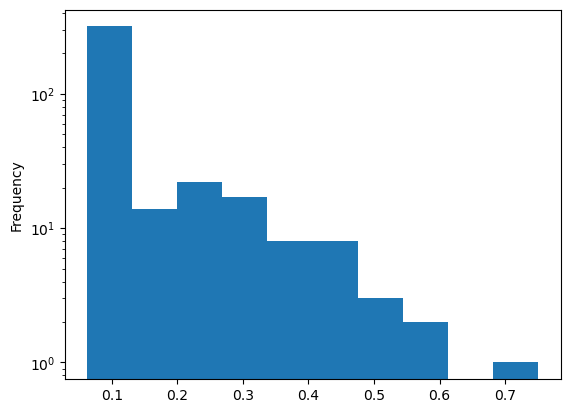

In [151]:
dmatDF_nz[dmatDF_nz.g1.str.contains("1655525")].HmmingDist.plot(kind="hist", logy=True)

In [94]:
import pandas as pd

# Create a list to store module data
module_data = []

# Iterate over the modules and prepare the data
for i, module in enumerate(gene_modules):
    module_id = f"Module_{i+1}"
    genes = list(module)
    for p in genes:
        module_data.append([module_id, p,p.split("_")[1]])  # Append module ID and gene

# Create a DataFrame from the module data
module_df = pd.DataFrame(module_data, columns=['Module_ID', 'ProbeName','ProbeID'])
module_df.head()


IndexError: list index out of range

# Validation  
1. extract genename from probe ID * extract mapping file from : https://support.illumina.com/downloads/humanht-12_v3_product_files.html
2. Load previos annotation BloodGen3
3. see the module composition difference

In [23]:
il12 = pd.read_csv("../data/mappingFiles/HumanHT-12_V3_0_R3_11283641_A.txt",sep="\t",skiprows=8)
probeDict_map = il12[['Probe_Id','ILMN_Gene']].dropna().set_index('Probe_Id').to_dict()['ILMN_Gene']

In [25]:
bg3_pub = pd.read_excel("../data/pubdata/41467_2021_24584_MOESM4_ESM.xlsx",sheet_name="Supplementary_Table_vDEC2019")

In [39]:
bg3_pub.head()

,Items,ID,Aggregate number,Aggregate location,Module title,Number of unique genes,Module Probe IDs,Member genes,Literature Lab Top Associations,GSAnRes annotation,...,Enrichment p-value.3,Gene Count.4,Top matched Chaussabel gen2 module,Annotation of gen2 module,Gene Count.5,Percent of module,Top matched Emory module,Annotation of Emory module,Gene Count.6,Percent of module.1
0,1,M3.1,A29,1,Cell cycle,106,"1693789, 1787314, 1730678, 2188119, 1678757, 2...","ALPP, ALS2CR14, ANKRD30B, ARL16, BCYRN1, BLZF1...",Signs and Symptoms/Homeostasis/Link,NaN,...,0.589604,20.0,M2.1,Cell Cycle,43.0,39.45,M246,TBA,4.0,0.037736
1,2,M8.1,A29,4,TBD,51,"1812640, 2261519, 2405684, 2134381, 2211724, 1...","AHR, AIRE, BIRC3, C14ORF85, C21ORF24, C21ORF55...",Cyclic AMP/Cyclic AMP/Gastroenteritis,NaN,...,NaN,NaN,M2.1,Cell Cycle,7.0,13.46,M11.0,enriched in monocytes (II),2.0,0.039216
2,3,M8.2,A34,4,Prostanoids,36,"1789627, 1677814, 1656940, 1713731, 2090004, 1...","ABCC3, ABLIM3, ALOX12, AQP10, C6ORF21, C7ORF41...",Integrin beta3/Calmodulin-Binding Proteins/Pla...,"platelet degranulation, protein metabolic proc...",...,0.994313,3.0,M1.1,Platelets,30.0,81.08,M51,cell adhesion,9.0,0.250000
3,4,M8.3,A28,6,Type 1 Interferon,17,"2388547, 1729749, 1653466, 1760062, 1723912, 2...","EPSTI1, HERC5, HES4, IFI44, IFI44L, IFI6, IFIT...",Transcriptome/Transcriptome/Orthomyxoviridae I...,"defense response to virus, nucleobase-containi...",...,0.105091,3.0,M1.2,IFN,18.0,85.71,M75,antiviral IFN signature,5.0,0.294118
4,5,M9.1,A2,1,Cytotoxic lymphocytes,28,"1716276, 1742001, 1796423, 2073184, 1760509, 1...","CCL4L2, CD160, CLIC3, EDG8, EOMES, FGFBP2, GNL...",Cytotoxins/Granzyme A/Granzymes,"protein-containing complex assembly, signal tr...",...,0.027161,3.0,M3.6,Cytotoxic/NK,21.0,65.62,M7.2,enriched in NK cells (I),18.0,0.642857


In [51]:
bg3_pubDF = []#pd.DataFrame(columns=['ID','Genes','Probes'])
for k in bg3_pub.index:
    m_name = bg3_pub.loc[k,'ID']
    genes = bg3_pub.loc[k,'Member genes'].split(",")
    probes = bg3_pub.loc[k,'Module Probe IDs'].split(",")
    for p,g in zip(probes,genes):
        bg3_pubDF.append([m_name,g,p,bg3_pub.loc[k,'Module title']])
bg3_pubDF = pd.DataFrame(bg3_pubDF,columns=['ID','Genes','Probes','modtitle'])
bg3_pubDF['Probes'] = bg3_pubDF['Probes'].str.strip()
bg3_pubDF['Genes'] = bg3_pubDF['Genes'].str.strip()
bg3_pubDF['ID'] = bg3_pubDF['ID'].str.strip()
bg3_pubDF.head()

,ID,Genes,Probes,modtitle
0,M3.1,ALPP,1693789,Cell cycle
1,M3.1,ALS2CR14,1787314,Cell cycle
2,M3.1,ANKRD30B,1730678,Cell cycle
3,M3.1,ARL16,2188119,Cell cycle
4,M3.1,BCYRN1,1678757,Cell cycle


In [121]:
bg3_pubDF['outerloop'] = bg3_pubDF['ID'].str.split(".").str[0].str[1:]
bg3_pubDF['innerloop'] = bg3_pubDF['ID'].str.split(".").str[1]
bg3_pubDF['outerloop'] = bg3_pubDF['outerloop'].astype(int)
bg3_pubDF['innerloop'] = bg3_pubDF['innerloop'].astype(int)

bg3_pubDF.sort_values(by=['outerloop','innerloop'],inplace=True)

In [123]:
bg3_pubDF

,ID,Genes,Probes,modtitle,outerloop,innerloop
0,M3.1,ALPP,1693789,Cell cycle,3,1
1,M3.1,ALS2CR14,1787314,Cell cycle,3,1
2,M3.1,ANKRD30B,1730678,Cell cycle,3,1
3,M3.1,ARL16,2188119,Cell cycle,3,1
4,M3.1,BCYRN1,1678757,Cell cycle,3,1
...,...,...,...,...,...,...
14499,M16.111,RAD1,1737635,TBD,16,111
14500,M16.111,TMSB4Y,1776195,TBD,16,111
14501,M16.111,TNFRSF21,1699695,TBD,16,111
14502,M16.111,UTP15,1735908,TBD,16,111


In [125]:
bg3_pubDF[bg3_pubDF.ID=="M3.1"]

,ID,Genes,Probes,modtitle,outerloop,innerloop
0,M3.1,ALPP,1693789,Cell cycle,3,1
1,M3.1,ALS2CR14,1787314,Cell cycle,3,1
2,M3.1,ANKRD30B,1730678,Cell cycle,3,1
3,M3.1,ARL16,2188119,Cell cycle,3,1
4,M3.1,BCYRN1,1678757,Cell cycle,3,1
...,...,...,...,...,...,...
104,M3.1,ZNF652,2155322,Cell cycle,3,1
105,M3.1,ZNF669,2093748,Cell cycle,3,1
106,M3.1,ZNF682,2313889,Cell cycle,3,1
107,M3.1,ZNF69,2176882,Cell cycle,3,1


In [137]:
bg3_pubDF.Probes.nunique(),bg3_pubDF.Genes.nunique()

(14504, 11465)

In [139]:
_dlist = [i.split("_")[1] for i in dist_matrixDF_frac.index.tolist()]
print (len(set(_dlist)), len(_dlist))

12669 12669


In [142]:
bg3_pubDF[bg3_pubDF.Probes.isin(set(bg3_pubDF[bg3_pubDF.ID=="M3.1"].Probes).intersection(set(_dlist)))]

,ID,Genes,Probes,modtitle,outerloop,innerloop
1,M3.1,ALS2CR14,1787314,Cell cycle,3,1
7,M3.1,C11ORF63,2243516,Cell cycle,3,1
12,M3.1,C9ORF130,1738678,Cell cycle,3,1
16,M3.1,CYCSL1,2061419,Cell cycle,3,1
27,M3.1,FLJ38717,1771320,Cell cycle,3,1
32,M3.1,GSTTP2,2246548,Cell cycle,3,1
36,M3.1,HS.562875,1915783,Cell cycle,3,1
37,M3.1,HS.571741,1870457,Cell cycle,3,1
38,M3.1,HS.576072,1916457,Cell cycle,3,1
45,M3.1,LEP,2207505,Cell cycle,3,1


<Axes: ylabel='Frequency'>

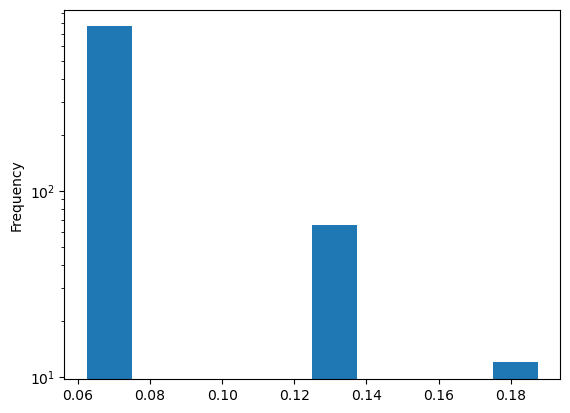

In [148]:
dmatDF_nz[dmatDF_nz.g1.str.contains("1787314")].HmmingDist.plot(kind="hist", logy=True)

## Validation for approach 1

In [45]:
fix_bg3MT['geneName'] = fix_bg3MT.gene.map(probeDict_map)
fix_bg3MT.head()

,gene,moduleID,Loop,geneName
0,ILMN_1730487,M2.1,L2,CALD1
1,ILMN_1715417,M2.1,L2,SELP
2,ILMN_2090004,M2.1,L2,AQP10
3,ILMN_1671486,M2.1,L2,HOMER2
4,ILMN_1657708,M2.1,L2,MGLL


In [46]:
glist = [k.strip() for k in bg3_pub[bg3_pub.ID=="M3.1"]['Member genes'].values[0].split(",")]
fix_bg3MT[fix_bg3MT.geneName.isin(glist)].moduleID.unique()

array(['M5.3', 'M7.3', 'M7.6', 'M7.18', 'M7.24', 'M7.25', 'M8.9', 'M8.15',
       'M8.17', 'M8.20', 'M8.21', 'M8.29', 'M8.31', 'M9.2', 'M9.7',
       'M9.13', 'M9.14', 'M10.3', 'M10.10', 'M10.16', 'M10.20', 'M10.26',
       'M11.3', 'M11.4', 'M11.11', 'M11.12', 'M11.23', 'M11.26', 'M11.27',
       'M11.28', 'M12.2', 'M12.8', 'M12.10', 'M13.3', 'M13.14', 'M13.20',
       'M13.22'], dtype=object)

## Validation for approach 2

In [80]:
module_df['geneName'] = module_df.ProbeName.map(probeDict_map)
module_df.head()

,Module_ID,ProbeName,ProbeID,geneName
0,Module_1,ILMN_2096759,2096759,PSMC6
1,Module_1,ILMN_1674411,1674411,CKAP2
2,Module_1,ILMN_1714756,1714756,YIPF5
3,Module_1,ILMN_2178855,2178855,GPAM
4,Module_1,ILMN_1778617,1778617,TAF9


In [82]:
dx_commm = module_df.set_index('ProbeID').join(bg3_pubDF.set_index("Probes")).sort_values(by=['Module_ID','ID'])

In [87]:
dx_commm.modtitle.unique()

array(['Gene transcription', 'Cell cycle', 'TBD', 'Antigen presentation',
       'B cells', 'Platelet', 'T cells', 'Protein modification',
       'Monocytes', 'TGF-beta', 'Protein phosphorylation', nan,
       'Interferon', 'Protein synthesis', 'Platelet/Prostaglandin',
       'Erythrocytes', 'Prostanoids', 'Cytotoxic lymphocytes',
       'Proteolysis', 'Inflammation', 'Complement', 'Cell death',
       'Cytokines/chemokines', 'Neutrophils', 'Oxidative stress',
       'Oxidative phosphorylation', 'Cell adhesion', 'TNF', 'Lymphocyte',
       'Mitochondrial Stress/Proteasome', 'Lipid metabolism',
       'Leukocyte activation'], dtype=object)

In [88]:
dx_commm[dx_commm.modtitle=="Interferon"]

,Module_ID,ProbeName,geneName,ID,Genes,modtitle
ProbeID,,,,,,
1783276,Module_10,ILMN_1783276,NEXN,M15.64,NEXN,Interferon
1697925,Module_109,ILMN_1697925,APOB48R,M15.64,APOB48R,Interferon
1656042,Module_114,ILMN_1656042,KIAA0319L,M15.64,KIAA0319L,Interferon
2325338,Module_130,ILMN_2325338,APOL2,M15.64,APOL2,Interferon
2367070,Module_142,ILMN_2367070,ACOT9,M15.64,ACOT9,Interferon
1681721,Module_161,ILMN_1681721,OASL,M15.127,OASL,Interferon
1656910,Module_161,ILMN_1656910,TRIM6,M15.127,TRIM6,Interferon
1670305,Module_161,ILMN_1670305,SERPING1,M15.127,SERPING1,Interferon
1835092,Module_161,ILMN_1835092,HS.125087,M15.127,HS.125087,Interferon


In [445]:
def find_maximum_cliques(graph):
    """
    Find all maximum cliques in the co-cluster graph.
    
    Parameters:
    - graph: A NetworkX graph representing the co-cluster network.
    
    Returns:
    - max_cliques: List of lists, where each list represents a maximum clique (a set of fully connected probes).
    """
    # Find all cliques in the graph
    cliques = list(nx.find_cliques(graph))
    
    # Sort cliques by size (optional)
    max_cliques = sorted(cliques, key=lambda x: len(x), reverse=True)
    
    return max_cliques

# Example usage
max_cliques = find_maximum_cliques(G)
print(f"Found {len(max_cliques)} cliques")


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x104eb1210>>
Traceback (most recent call last):
  File "/Users/khant/miniconda3/envs/py3_10/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


: 

In [ ]:
# first graph filtering by degree
def filter_graph_by_degree(graph, min_degree):
    """
    Filter the graph to keep only nodes with degree >= min_degree.
    
    Parameters:
    - graph: A NetworkX graph.
    - min_degree: int, minimum degree to keep a node.
    
    Returns:
    - filtered_graph: A NetworkX graph with nodes filtered by degree.
    """
    filtered_nodes = [node for node, degree in graph.degree() if degree >= min_degree]
    filtered_graph = graph.subgraph(filtered_nodes)
    
    return filtered_graph

In [443]:
def expand_paraclique(graph, clique, threshold, paraclique_threshold):
    """
    Expand a clique into a paraclique by adding nodes that co-cluster with at least paraclique_threshold % of the clique members.
    
    Parameters:
    - graph: A NetworkX graph representing the co-cluster network.
    - clique: A list representing a maximum clique.
    - threshold: float, the co-clustering threshold for adding an edge.
    - paraclique_threshold: float, the percentage of clique members that a node must co-cluster with to be added to the paraclique.
    
    Returns:
    - paraclique: A set representing the expanded paraclique.
    """
    paraclique = set(clique)  # Start with the original clique
    
    # Iterate over all nodes not in the clique
    for node in graph.nodes:
        if node not in clique:
            # Count how many members of the clique this node connects with
            connections = sum(1 for member in clique if graph.has_edge(node, member))
            # Add the node to the paraclique if it connects with at least paraclique_threshold % of the clique
            if connections >= paraclique_threshold * len(clique):
                paraclique.add(node)
    
    return paraclique

# Example usage
paraclique_threshold = 0.9  # For example, 90% of the clique members
expanded_paracliques = [expand_paraclique(G, clique, threshold, paraclique_threshold) for clique in max_cliques]


array([[1.    , 0.1875, 0.375 , ..., 0.    , 0.0625, 0.    ],
       [0.1875, 1.    , 0.1875, ..., 0.    , 0.    , 0.    ],
       [0.375 , 0.1875, 1.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 1.    , 0.    , 0.    ],
       [0.0625, 0.    , 0.    , ..., 0.    , 1.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 1.    ]])

In [ ]:
def extract_modules(paracliques):
    """
    Extract modules from the expanded paracliques.
    
    Parameters:
    - paracliques: List of sets, where each set is a paraclique.
    
    Returns:
    - modules: List of named modules.
    """
    modules = []
    
    for i, paraclique in enumerate(paracliques):
        module_name = f"Module_{i+1}"
        modules.append((module_name, paraclique))
    
    return modules

# Example usage
modules = extract_modules(expanded_paracliques)
for module_name, module in modules:
    print(f"{module_name}: {len(module)} genes")


# write the code with chat GPT

step1 :

In [306]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.stats import pearsonr


def cluster_dataset(data, max_clusters=100, correlation_threshold=0.3):
    """
    Clusters the dataset using K-Means and checks Pearson correlation of clusters.
    
    Parameters:
    - data: np.ndarray, rows are probes and columns are samples (expression data).
    - max_clusters: int, maximum number of clusters to test.
    - correlation_threshold: float, Pearson correlation threshold for cluster acceptance.
    
    Returns:
    - labels: cluster labels for the probes if clustering succeeds.
    """
    for k in range(1, max_clusters+1):
        print(f"Clustering with k = {k} clusters...")
        
        # Perform K-Means clustering
        kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
        labels = kmeans.labels_
        
        # Check the Pearson correlation for each cluster
        for cluster in np.unique(labels):
            # Get the probes in this cluster
            cluster_indices = np.where(labels == cluster)[0]
            cluster_data = data[cluster_indices]
            
            # Calculate the mean expression profile (centroid) for the cluster
            mean_vector = np.mean(cluster_data, axis=0)
            
            # Calculate Pearson correlation for each probe with the mean vector
            correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]
            avg_correlation = np.mean(correlations)
            
            # Check if the average correlation is below the threshold
            if avg_correlation < correlation_threshold:
                print(f"Cluster at k={k} rejected due to low correlation (avg correlation: {avg_correlation:.2f}). Restarting at k={k-1}")
                return cluster_dataset(data, max_clusters=k+1)
        
        # If we reach here, the clustering passed the correlation check
        return labels

    return None  # If no clustering is successful


In [309]:
from scipy.stats import pearsonr

def hartigan_kmeans(data, initial_clusters, correlation_threshold=0.3, max_iter=100):
    """
    Implementation of Hartigan's K-Means with a Pearson correlation check.
    
    Parameters:
    - data: np.ndarray, rows are probes and columns are samples.
    - initial_clusters: int, initial number of clusters.
    - correlation_threshold: float, Pearson correlation threshold.
    - max_iter: int, maximum number of iterations to perform.
    
    Returns:
    - labels: cluster labels for each probe.
    """
    n_samples = data.shape[0]
    labels = np.random.randint(0, initial_clusters, size=n_samples)
    centroids = np.zeros((initial_clusters, data.shape[1]))
    
    for iteration in range(max_iter):
        # Update centroids
        for k in range(initial_clusters):
            if np.sum(labels == k) > 0:
                centroids[k] = np.mean(data[labels == k], axis=0)
        
        # Point-by-point reassignment
        for i in range(n_samples):
            best_cluster = labels[i]
            best_cost = np.inf  # High cost to ensure reassignment
            
            for k in range(initial_clusters):
                if k == labels[i]:
                    continue
                
                # Calculate the cost of moving to cluster k (e.g., using Euclidean distance)
                new_centroid = np.mean(data[labels == k], axis=0)
                cost = np.linalg.norm(data[i] - new_centroid)
                
                # Check Pearson correlation with the new centroid
                corr, _ = pearsonr(data[i], new_centroid)
                
                if cost < best_cost and corr >= correlation_threshold:
                    best_cost = cost
                    best_cluster = k
            
            # Reassign if the new cluster is better
            labels[i] = best_cluster
        
        # Check convergence (no label changes)
        if np.all(labels == best_cluster):
            break

    return labels

In [317]:
data = processed_files['MS']
print (data.shape)

(7665, 56)


In [326]:
n_samples, n_features = data.shape
initial_clusters=10
correlation_threshold=0.3
max_iter=100

labels = np.random.randint(0, initial_clusters, size=n_samples)
centroids = np.zeros((initial_clusters, n_features))



def hartigan_kmeans(data, initial_clusters, correlation_threshold=0.3, max_iter=100):
    """
    Implementation of Hartigan's K-Means with Pearson correlation check.
    
    Parameters:
    - data: np.ndarray, rows are probes and columns are samples (expression data).
    - initial_clusters: int, number of clusters to initialize.
    - correlation_threshold: float, Pearson correlation threshold.
    - max_iter: int, maximum number of iterations.
    
    Returns:
    - labels: Cluster labels for each probe.
    - centroids: Final centroids for each cluster.
    """
    n_samples, n_features = data.shape
    labels = np.random.randint(0, initial_clusters, size=n_samples)
    centroids = np.zeros((initial_clusters, n_features))
    
    # Initial centroids calculation
    for k in range(initial_clusters):
        if np.sum(labels == k) > 0:  # Ensure the cluster is not empty
            centroids[k] = np.mean(data[labels == k], axis=0)

    for iteration in range(max_iter):
        has_changed = False
        
        # Point-by-point reassignment
        for i in range(n_samples):
            current_label = labels[i]
            best_label = current_label
            best_cost = np.linalg.norm(data[i] - centroids[current_label])  # Current cost (Euclidean distance)
            
            # Try assigning the point to each cluster and check correlation
            for k in range(initial_clusters):
                if k == current_label:  # Skip if it's the current cluster
                    continue
                
                # Calculate the Pearson correlation between the data point and the new cluster centroid
                corr, _ = pearsonr(data[i], centroids[k])
                
                if corr >= correlation_threshold:  # Check correlation threshold
                    # Calculate the cost (Euclidean distance to the new centroid)
                    new_cost = np.linalg.norm(data[i] - centroids[k])
                    
                    if new_cost < best_cost:  # Only move if the cost is lower
                        best_label = k
                        best_cost = new_cost
            
            # Reassign the point to the best cluster found
            if best_label != current_label:
                labels[i] = best_label
                has_changed = True
        
        # Update centroids after reassignment
        for k in range(initial_clusters):
            if np.sum(labels == k) > 0:  # Update only non-empty clusters
                centroids[k] = np.mean(data[labels == k], axis=0)
        
        # Stop if no points were reassigned
        if not has_changed:
            print(f"Converged after {iteration+1} iterations.")
            break
    
    return labels, centroids


In [327]:
# Example test with synthetic data
np.random.seed(42)

# Create some synthetic data (e.g., 100 probes, 5 samples)
data = np.random.rand(100, 5)

# Run the Hartigan's K-Means with Pearson correlation check
labels, centroids = hartigan_kmeans(data, initial_clusters=5, correlation_threshold=0.3, max_iter=100)

print("Cluster labels:", labels)
print("Cluster centroids:", centroids)

Converged after 6 iterations.
Cluster labels: [2 4 2 2 1 0 3 3 3 0 0 1 2 4 3 1 1 2 4 1 4 2 0 3 1 2 3 4 1 2 3 4 2 1 1 0 0
 0 2 4 3 2 4 4 1 4 0 3 0 3 2 0 4 0 0 4 1 4 2 0 4 0 3 1 4 0 1 2 1 1 2 3 4 2
 3 3 4 3 3 3 2 3 4 3 1 0 2 0 4 0 0 1 4 4 4 3 4 3 1 3]
Cluster centroids: [[0.68081778 0.57202994 0.66132347 0.63519525 0.22156624]
 [0.68607109 0.45740565 0.25262078 0.21215277 0.32606402]
 [0.22093289 0.63635707 0.71871156 0.35475931 0.2098443 ]
 [0.66443166 0.32426864 0.21663233 0.80615617 0.60844481]
 [0.28660715 0.64491412 0.60672857 0.52681966 0.7891064 ]]


In [330]:
data = np.array(processed_files['MS'])
print (data.shape)


# Run the Hartigan's K-Means with Pearson correlation check
labels, centroids = hartigan_kmeans(data, initial_clusters=5, correlation_threshold=0.3, max_iter=100)

print("Cluster labels:", labels)
print("Cluster centroids:", centroids)

(7665, 56)
Converged after 40 iterations.
Cluster labels: [1 1 1 ... 2 1 3]
Cluster centroids: [[0.07057579 0.07601035 0.05918245 0.10856462 0.12059185 0.22217384
  0.13125943 0.1707725  0.38490481 0.2044717  0.22615809 0.12493473
  0.19039957 0.25052144 0.08312476 0.11583223 0.08393939 0.04406909
  0.08874839 0.34067955 0.23338813 0.10061898 0.11325081 0.10845972
  0.65772282 0.22499091 0.05561202 0.07236021 0.05626248 0.06212953
  0.06214565 0.06238035 0.11210068 0.14004561 0.07304355 0.08699676
  0.23428534 0.12257739 0.2445982  0.24174613 0.21192893 0.55997181
  0.54457158 0.16982803 0.32890938 0.17348651 0.15626461 0.09659741
  0.10529115 0.52271744 0.31644386 0.26064845 0.24629838 0.0668819
  0.06379267 0.335139  ]
 [0.16132117 0.20244935 0.14645489 0.10956336 0.16466691 0.13327174
  0.11988394 0.12799479 0.0790985  0.23133951 0.09692464 0.10049132
  0.11042291 0.07170276 0.13914767 0.12657918 0.09465314 0.07184978
  0.21938791 0.07218638 0.09440777 0.48113802 0.14046096 0.124402

In [334]:
tmpx = pd.DataFrame(labels,index=processed_files['MS'].index,columns=['MS_Cluster'])
tmpx.MS_Cluster.value_counts()

MS_Cluster
3    1947
0    1858
1    1361
4    1308
2    1191
Name: count, dtype: int64

In [367]:
            import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

def kmeans_with_correlation_threshold(data, max_clusters=100, min_clusters=1, correlation_threshold=0.3):
    """
    Perform KMeans clustering with Pearson correlation check.
    If any cluster's average Pearson correlation is below the threshold, retry with k-1 clusters.
    
    Parameters:
    - data: np.ndarray, rows are probes and columns are samples (expression data).
    - max_clusters: int, maximum number of clusters to initialize.
    - min_clusters: int, minimum number of clusters to try (usually 1).
    - correlation_threshold: float, Pearson correlation threshold for validating clusters.
    
    Returns:
    - labels: np.ndarray, cluster labels for each probe for the best k found.
    - best_k: int, the best number of clusters found.
    - valid_clusters: list, valid clusters that passed the Pearson correlation check.
    """
    best_k = None
    labels = None
    valid_clusters = []

    for k in range(max_clusters, min_clusters - 1, -1):
        print(f"Clustering with k = {k} clusters...")
        
        # Step 1: Perform K-Means clustering
        kmeans = KMeans(n_clusters=k, random_state=99, init='k-means++', max_iter=100, n_init=10,)
        labels = kmeans.fit_predict(data)
        
        # Retrieve the cluster centroids
        centroids = kmeans.cluster_centers_
        
        # Step 2: Check Pearson correlation for each cluster
        is_valid_k = True
        for cluster in range(k):
            # Get the indices of the probes in this cluster
            cluster_indices = np.where(labels == cluster)[0]


            # Check if the cluster size is 1
            if len(cluster_indices) == 1:
                print(f"Cluster {cluster} has only 1 member, will retry with k={k-1}.")
                is_valid_k = False
                break
            
            cluster_data = data[cluster_indices]
            
            # Calculate the mean expression profile (centroid) for the cluster
            mean_vector = centroids[cluster]
            
            # Calculate Pearson correlation for each probe in the cluster
            correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]
            avg_correlation = np.mean(correlations)
            
            # If the average correlation for this cluster is below the threshold, reject k
            if avg_correlation <= correlation_threshold:
                print(f"Cluster {cluster} rejected at k<={k} due to low average correlation ({avg_correlation:.2f}). Restarting with k={k-1}")
                is_valid_k = False
                break  # No need to check further clusters at this k
        
        if is_valid_k:
            # We found a valid clustering at this k
            best_k = k
            valid_clusters = [np.where(labels == cluster)[0] for cluster in range(k)]
            break

    if best_k is None:
        print("No valid clustering found within the range.")
    else:
        print(f"Best k found: {best_k}")
    
    return labels, best_k, valid_clusters

# Example usage with synthetic data
np.random.seed(42)

# Generate synthetic data (e.g., 100 probes, 5 samples)
data = np.random.rand(100, 5)

# Perform KMeans clustering with Pearson correlation check and decreasing k
max_clusters = 100
correlation_threshold = 0.3
labels, best_k, valid_clusters = kmeans_with_correlation_threshold(data, max_clusters, min_clusters=25, correlation_threshold=correlation_threshold)

print(f"Best number of clusters (k): {best_k}")



Clustering with k = 100 clusters...
Best k found: 100
Best number of clusters (k): 100


In [371]:
processed_files.keys()

dict_keys(['MS', 'COPD', 'SLE', 'Kawasaki', 'Melanoma', 'Flu', 'B_Cell_Deficiency', 'Pregnancy', 'Liver_Transplant', 'Juvenile_Dermatomyositis', 'HIV', 'Sepsis', 'Staph', 'SoJIA', 'RSV', 'TB'])

In [373]:
# Perform KMeans clustering with Pearson correlation check
data = np.array(processed_files['Melanoma'])
print (data.shape)
max_clusters=100
min_clusters=25
correlation_threshold = 0.30

labels,  best_k, valid_clusters = kmeans_with_correlation_threshold(data, max_clusters, min_clusters=25, correlation_threshold=correlation_threshold)
print(f"Best number of clusters (k): {best_k}")


(8455, 27)
Clustering with k = 100 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 86 has only 1 member, will retry with k=99.
Clustering with k = 99 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 86 has only 1 member, will retry with k=98.
Clustering with k = 98 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 58 has only 1 member, will retry with k=97.
Clustering with k = 97 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 86 has only 1 member, will retry with k=96.
Clustering with k = 96 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 86 has only 1 member, will retry with k=95.
Clustering with k = 95 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 86 has only 1 member, will retry with k=94.
Clustering with k = 94 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 86 has only 1 member, will retry with k=93.
Clustering with k = 93 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 31 has only 1 member, will retry with k=92.
Clustering with k = 92 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 86 has only 1 member, will retry with k=91.
Clustering with k = 91 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 33 has only 1 member, will retry with k=90.
Clustering with k = 90 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 41 has only 1 member, will retry with k=89.
Clustering with k = 89 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 64 has only 1 member, will retry with k=88.
Clustering with k = 88 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 86 has only 1 member, will retry with k=87.
Clustering with k = 87 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 69 has only 1 member, will retry with k=86.
Clustering with k = 86 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 49 has only 1 member, will retry with k=85.
Clustering with k = 85 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 71 has only 1 member, will retry with k=84.
Clustering with k = 84 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 49 has only 1 member, will retry with k=83.
Clustering with k = 83 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Cluster 49 has only 1 member, will retry with k=82.
Clustering with k = 82 clusters...


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/1432775700.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]


Best k found: 82
Best number of clusters (k): 82


In [374]:
tmpx = pd.DataFrame(labels,index=processed_files['Melanoma'].index,columns=['MS_Cluster'])
tmpx.MS_Cluster.value_counts().sort_values()

MS_Cluster
20      1
39      1
19      2
40      2
61      2
     ... 
3     314
1     318
74    327
69    335
45    433
Name: count, Length: 82, dtype: int64

In [82]:
f=pd.read_csv("../data/geoData/GSE100151_HIV_normalized.txt.gz",compression='gzip',sep='\t',index_col=0)
fpval = f[f.columns[f.columns.str.contains("Pval")]]
detecttion_cutoff = 0.01
probes_detected = fpval[fpval<detecttion_cutoff].fillna(0).astype(bool).sum(axis=1).sort_values(ascending=False)
# consider probes that have passed detection threshold in at-least 10% of samples
probes_detected = probes_detected[probes_detected>0.1*f.shape[1]]
f = f.loc[probes_detected.index]
f.shape

(7552, 126)

In [7]:
# filter data and take only detection values
ffilter = f.drop(fpval.columns,axis=1)
ffilter.shape

(7552, 63)

<Axes: >

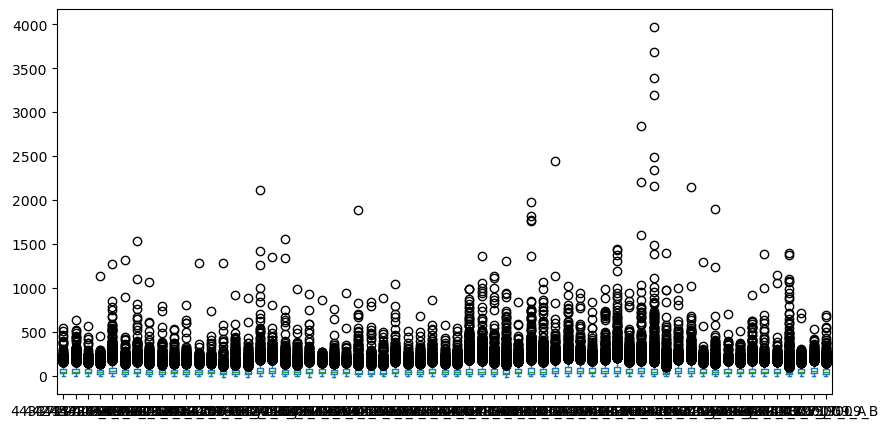

In [8]:
ffilter.plot(kind='box',figsize=(10,5))

In [9]:
#check non onormalized data
fraw = pd.read_csv("/Users/khant/JaX_work/FixMT_project/redoBloodGen3/data/geoData_nonNormalized/GSE100151_HIV_non-normalized.txt.gz",compression='gzip',sep='\t',index_col=0)

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_65681/3847236211.py:2: DtypeWarning: Columns (127,128,129,130,131,132,133) have mixed types. Specify dtype option on import or set low_memory=False.
  fraw = pd.read_csv("/Users/khant/JaX_work/FixMT_project/redoBloodGen3/data/geoData_nonNormalized/GSE100151_HIV_non-normalized.txt.gz",compression='gzip',sep='\t',index_col=0)


<Axes: >

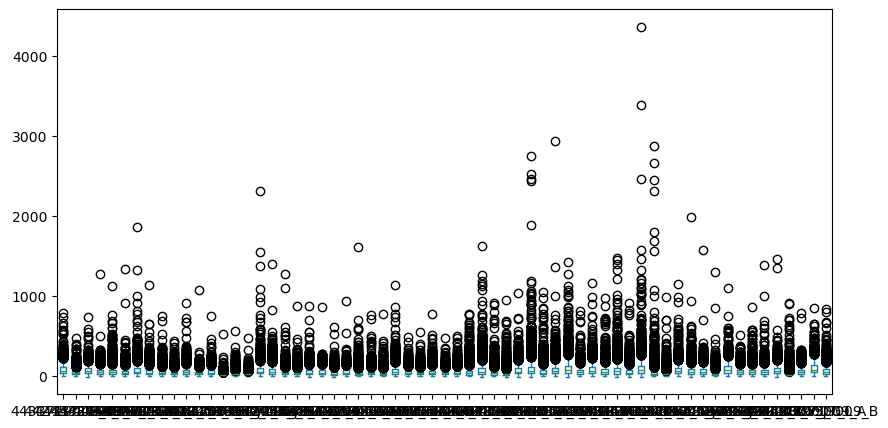

In [10]:
fraw.loc[probes_detected.index][ffilter.columns].plot(kind='box',figsize=(10,5))

In [11]:
#  the signal was transformed such that all signals <10 were set to 10.
ffilter = ffilter.clip(10)

In [12]:
ffilter

,4433719009_D,4424548056_A,4433719009_G,4433719009_I,4424548056_G,4433719009_K,4433719010_A,4433719010_C,4433719010_G,4424548057_D,...,4424548053_G,4433719006_L,4433719007_A,4424548055_A,4433719007_F,4433719007_J,4424548055_G,4433719007_L,4433719009_A,4433719009_B
ID_REF,,,,,,,,,,,,,,,,,,,,,
ILMN_1786275,32.5260,29.9079,36.3431,32.6217,33.4680,30.9355,38.8814,28.4201,41.1812,40.5524,...,34.6488,34.4636,29.2038,41.4148,40.0099,39.7960,24.5083,41.5824,39.6235,30.2311
ILMN_2402079,34.4909,32.7728,24.1160,42.9377,37.7679,29.0742,45.4425,30.3425,32.9400,35.6731,...,25.0042,39.7097,39.6272,43.7336,39.3904,34.9023,23.2824,30.4294,38.3808,42.7050
ILMN_1655663,28.4787,49.8928,37.5974,30.5184,45.8044,24.8107,35.2239,37.0503,41.2343,35.5774,...,47.3686,27.4844,25.1483,35.6320,29.6670,45.5714,34.7059,36.5651,45.2702,32.3037
ILMN_1786684,39.5832,29.9019,30.0178,30.9604,34.0512,40.6088,38.8104,23.1133,32.5171,45.6439,...,37.7702,18.3458,38.5708,38.1916,48.0830,39.1144,37.5589,36.6573,35.6809,21.4555
ILMN_1770848,44.0912,24.1788,40.8857,25.0234,43.3599,23.2738,37.4909,26.9490,37.8723,34.1144,...,37.1267,26.3397,51.3811,42.8432,38.9504,56.7363,38.1092,33.0341,47.8956,41.5640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ILMN_1730773,203.8458,84.4151,221.2303,229.2229,162.9715,160.6694,147.3632,111.8291,79.3009,127.5663,...,61.3719,168.7973,219.3626,101.5817,163.4118,148.9963,33.8893,137.4406,240.6574,153.3495
ILMN_2390227,117.2473,169.8860,132.5597,125.9625,92.8518,105.4690,157.3746,133.3386,116.3239,135.3756,...,144.5784,167.1563,131.9667,127.4636,146.7617,146.7117,48.7673,62.4265,156.7389,115.4439
ILMN_1798472,18.0567,12.2204,10.0000,17.5813,13.3025,19.7508,13.8942,10.0000,10.0000,12.8572,...,10.0000,13.6414,12.5857,13.1487,13.1500,18.5376,10.0000,20.8361,27.6874,11.9048


In [13]:
# the fold change was calculated relative to the median signal for that probe across all samples
ffilter = ffilter.div(ffilter.median(axis=1),axis=0)
#  the calculated absolute magnitude of the fold change was <1.2, the fold change was set to 1 to reduce the noise from low-level responses
ffilter = ffilter.where(ffilter.abs()>1.2,1)
ffilter

,4433719009_D,4424548056_A,4433719009_G,4433719009_I,4424548056_G,4433719009_K,4433719010_A,4433719010_C,4433719010_G,4424548057_D,...,4424548053_G,4433719006_L,4433719007_A,4424548055_A,4433719007_F,4433719007_J,4424548055_G,4433719007_L,4433719009_A,4433719009_B
ID_REF,,,,,,,,,,,,,,,,,,,,,
ILMN_1786275,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.201697,1.000000,1.000000,1.0,1.206560,1.000000,1.000000
ILMN_2402079,1.000000,1.000000,1.00000,1.253967,1.000000,1.000000,1.327118,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.277210,1.000000,1.000000,1.0,1.000000,1.000000,1.247171
ILMN_1655663,1.000000,1.515361,1.00000,1.000000,1.391187,1.000000,1.000000,1.000000,1.252382,1.000000,...,1.438695,1.00000,1.000000,1.000000,1.000000,1.384110,1.0,1.000000,1.374962,1.000000
ILMN_1786684,1.239559,1.000000,1.00000,1.000000,1.000000,1.271676,1.215358,1.000000,1.000000,1.429351,...,1.000000,1.00000,1.207855,1.000000,1.505732,1.224878,1.0,1.000000,1.000000,1.000000
ILMN_1770848,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.383939,1.000000,1.000000,1.528181,1.0,1.000000,1.290058,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ILMN_1730773,1.606374,1.000000,1.74337,1.806354,1.284271,1.266129,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.33018,1.728652,1.000000,1.287740,1.000000,1.0,1.000000,1.896462,1.208446
ILMN_2390227,1.000000,1.460457,1.00000,1.000000,1.000000,1.000000,1.352900,1.000000,1.000000,1.000000,...,1.242895,1.43699,1.000000,1.000000,1.261664,1.261234,1.0,1.000000,1.347435,1.000000
ILMN_1798472,1.000000,1.000000,1.00000,1.000000,1.000000,1.262524,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.0,1.331899,1.769853,1.000000


In [14]:
# Probes were only retained if they had a calculated absolute fold change >1 in at least 10 samples or in at least 10% of the samples, whichever was greater. 
probes_detected = ffilter[ffilter.abs()>1].fillna(0).astype(bool).sum(axis=1).sort_values(ascending=False)
probes_detected = probes_detected[probes_detected>max(10,0.1*f.shape[1])]
ffilter = ffilter.loc[probes_detected.index]
ffilter.shape

(7274, 63)

<Axes: >

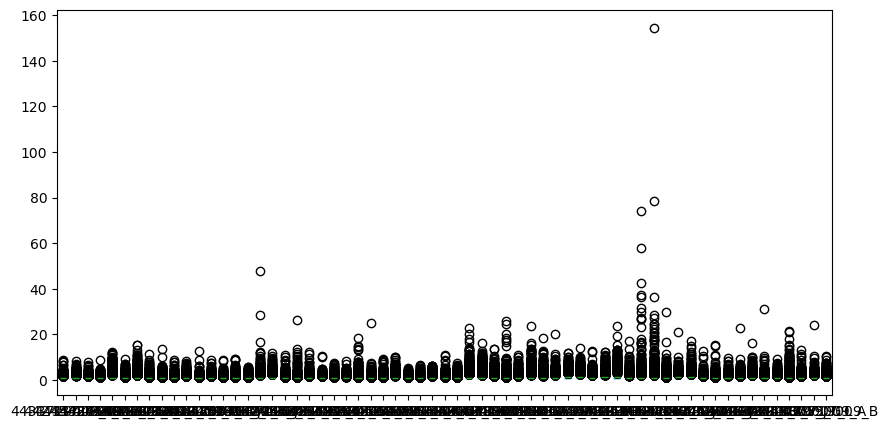

In [15]:
ffilter.plot(kind='box',figsize=(10,5))

In [16]:
# the data were transformed to the log2 of the calculated fold changes.
ffilter = np.log2(ffilter)
ffilter

,4433719009_D,4424548056_A,4433719009_G,4433719009_I,4424548056_G,4433719009_K,4433719010_A,4433719010_C,4433719010_G,4424548057_D,...,4424548053_G,4433719006_L,4433719007_A,4424548055_A,4433719007_F,4433719007_J,4424548055_G,4433719007_L,4433719009_A,4433719009_B
ID_REF,,,,,,,,,,,,,,,,,,,,,
ILMN_2412860,0.000000,2.320194,0.000000,0.0,3.252060,0.000000,0.000000,0.000000,0.000000,0.270651,...,0.766814,0.419615,0.000000,2.006763,0.000000,0.0,0.000000,0.0,0.000000,0.0
ILMN_1781942,0.000000,1.657379,0.286937,0.0,3.036914,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.333854,0.847398,0.000000,2.039907,0.567531,0.0,0.000000,0.0,0.000000,0.0
ILMN_1815184,0.000000,2.303741,0.000000,0.0,3.293335,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.676651,0.955785,0.000000,1.709951,0.786435,0.0,0.000000,0.0,0.000000,0.0
ILMN_2051373,0.000000,2.134144,0.000000,0.0,3.128280,1.501058,1.871771,0.000000,0.000000,0.000000,...,0.961620,0.360503,0.000000,1.439273,0.000000,0.0,0.000000,0.0,0.000000,0.0
ILMN_1652913,0.000000,2.239458,0.000000,0.0,2.607959,0.000000,0.706866,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.151632,1.102098,0.745648,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ILMN_2358914,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.361378,0.0
ILMN_1863939,0.000000,0.554815,0.000000,0.0,0.000000,0.402098,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.398182,0.000000,0.000000,0.0,0.415642,0.0,0.000000,0.0
ILMN_1675359,0.000000,0.561217,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.341957,0.000000,0.000000,0.466354,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [38]:
mdata_hiv

,sample_group,study_group
sample_ID,,
4433719001_L,Control,whole blood_HIV
4433719006_J,Control,whole blood_HIV
4433719006_L,Control,whole blood_HIV
4433719007_J,Control,whole blood_HIV
4433719007_L,Control,whole blood_HIV
...,...,...
4424548053_G,HIV,whole blood_HIV
4424548055_A,HIV,whole blood_HIV
4424548055_G,HIV,whole blood_HIV


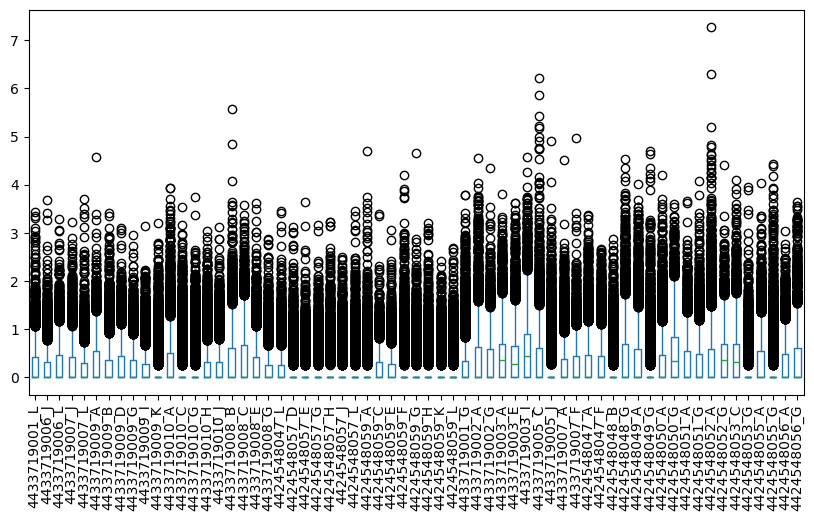

In [47]:
# make boxplot and color boxes as per sample_group
g = ffilter[mdata_hiv.index].plot(kind='box',figsize=(10,5),rot=90,legend=False)


In [62]:
mdata_hiv.sample_group.unique()

array(['Control', 'HIV'], dtype=object)

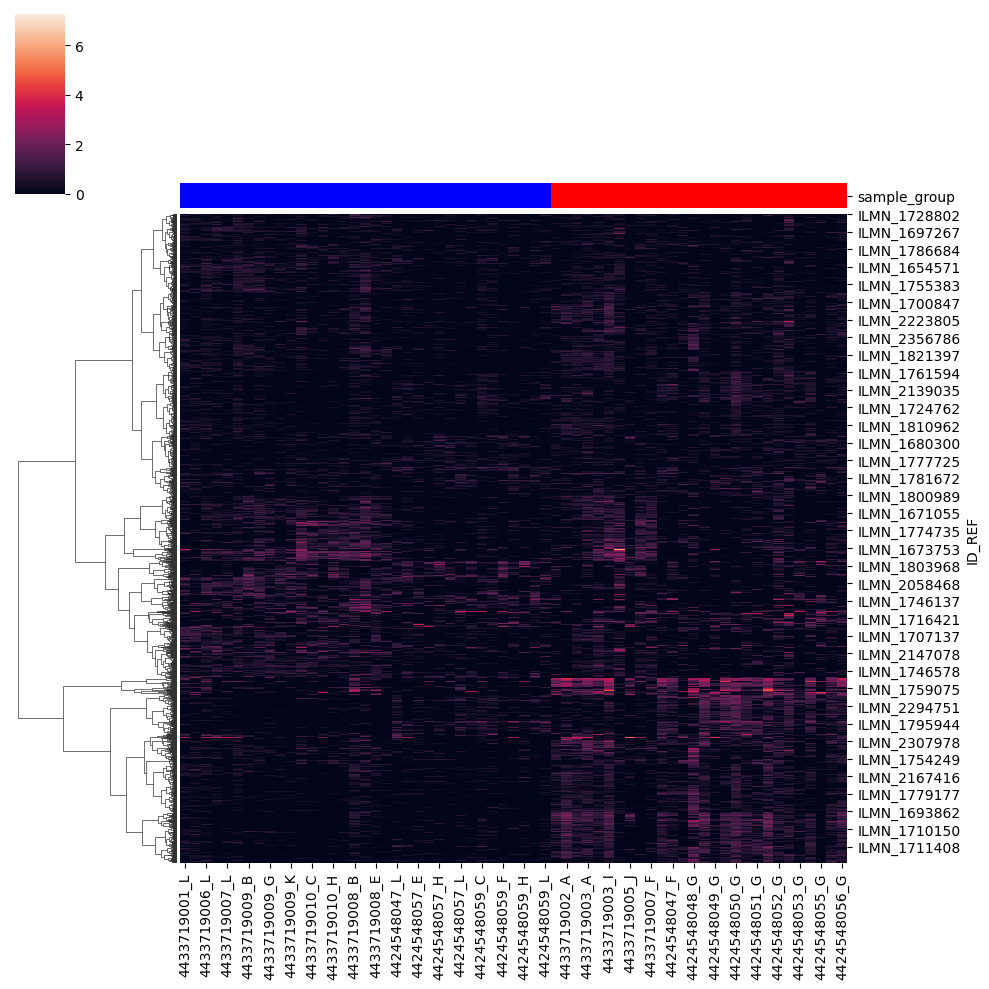

In [63]:
sns.clustermap(ffilter[mdata_hiv.index],method="ward",col_cluster=False,figsize=(10,10),
col_colors=mdata_hiv.sample_group.map({'HIV':'red','Control':'blue'}))

In [55]:
# clusters = {}
vr_crit = []

for i in range(25, 100):
    km = KMeans(n_clusters=i,random_state=1,max_iter=100).fit(ffilter)
    # clusters[kmer].append(km.inertia_)
    c_score = metrics.calinski_harabasz_score(ffilter, km.labels_) # Variance Ratio Criterion
    vr_crit.append([ i, km.inertia_, c_score])
clusterEnergy = pd.DataFrame(vr_crit, columns=['k', 'inertia', 'calinski_harabasz_score'])

In [149]:
clusterEnergy = test_clustering(processed_files['HIV'])

<Axes: xlabel='k', ylabel='inertia'>

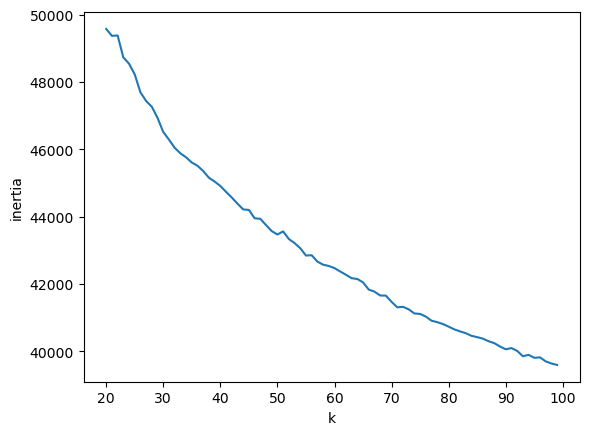

In [150]:
sns.lineplot(x="k",y="inertia",data=clusterEnergy)

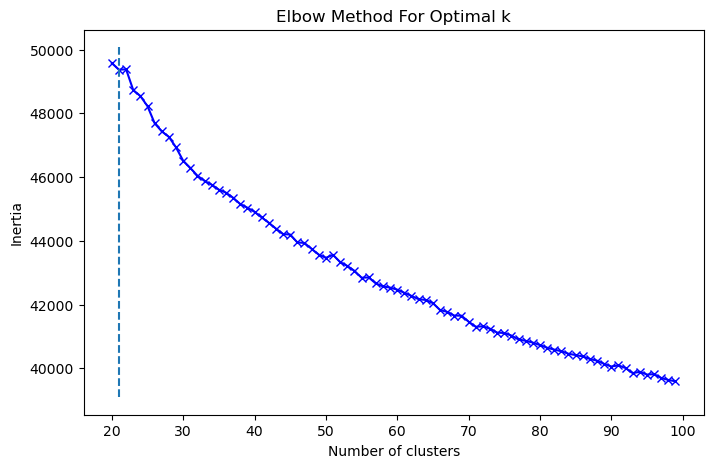

The optimal number of clusters is: 21


In [151]:



# Find the elbow point
kneedle = KneeLocator(clusterEnergy.k, clusterEnergy.inertia, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

# Plot the inertia values and the elbow point
plt.figure(figsize=(8, 5))
plt.plot(clusterEnergy.k, clusterEnergy.inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

print(f"The optimal number of clusters is: {elbow_point}")

In [66]:
# generate cluster with k= 42
km_hiv = KMeans(n_clusters=elbow_point,random_state=1,max_iter=100).fit(ffilter)

In [69]:
hiv_cc = pd.DataFrame(index=ffilter.index)
hiv_cc['cluster'] = km_hiv.labels_

In [71]:
hiv_cc.groupby('cluster').size()

cluster
0     102
1      43
2     281
3     244
4     137
5     257
6     361
7      91
8      39
9     170
10    106
11    138
12    262
13    532
14     80
15     41
16     37
17    221
18     68
19     94
20    167
21    256
22    423
23     17
24    100
25     24
26     73
27    309
28    157
29     78
30    120
31     23
32    151
33    200
34    185
35    543
36     10
37     50
38     76
39    394
40    484
41    130
dtype: int64